Updated by Leonardo Porcacchia on 08-10-2021. Email: leonardo.porcacchia@gmail.com

### Import libraries

In [1]:
import numpy as np

import sys
import os
import copy
import gc
import glob
import datetime
import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib as mpl

import netCDF4 as nc
from netCDF4 import Dataset as netcdf_dataset
from netCDF4 import date2num

from datetime import date, timedelta, datetime

from odimh5_file import OdimH5File
import h5py

import csv
import pandas as pd

from pyproj import Proj, Geod

import cartopy
from cartopy import config
import cartopy.crs as ccrs

import time

from scipy import stats
import statsmodels.api as sm
from statsmodels.distributions.mixture_rvs import mixture_rvs

from scipy.interpolate import griddata

import wradlib

%matplotlib notebook 
%matplotlib inline

### Define useful functions

In [2]:
def re2dh(r, elev, h0=0, R=6378137.0, dndh=-3.9e-8):
    elev = elev * np.pi/180 # to radians
    R_prim = 1.0 / (1.0/R + dndh)
    A_prim = R_prim + h0 +  r * np.sin(elev)
    B_prim = r * np.cos(elev)
    Lambda_prim = np.arctan(B_prim/A_prim)
    h = np.sqrt(A_prim**2 + B_prim**2) - R_prim
    d = R_prim * Lambda_prim
    return d, h 

In [3]:
def polar_plotter(a, rstart=0, rscale=500, ax=None, **kwargs):
    # take care of some keyword arguments
    figsize = kwargs.pop('figsize', (6, 6))
    aspect = kwargs.pop('aspect', 'equal')
    
    # setup figure and axis if missing
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        ax.set_aspect(aspect)
    
    # assume the dimensions of a are (nrays, nbins)
    nrays, nbins = a.shape
    # define set of angles and radii values
    # angles start at pi/2 to define North and go to -3*pi/2, i.e. clockwise
    theta = np.linspace(np.pi/2, -3*np.pi/2, nrays+1) # radians
    radii = np.linspace(rstart, rscale*nbins, nbins+1) # meters

    # create mesh of coordinates
    Radii, Theta = np.meshgrid(radii, theta)
    
    # transform coordinates
    X = Radii * np.cos(Theta)
    Y = Radii * np.sin(Theta)
    
    #fig, ax = plt.subplots()
    im = ax.pcolormesh(X, Y, a, **kwargs) #, vmin = -30, vmax = 60)
    fig.colorbar(im, ax=ax)
    
    return ax

#### Calculate Dual-polarization Ratio (DR), Kilambi et al. (2018)

In [4]:
def calculate_DR(ZDR,RHO):
    
    Zdr = 10**(ZDR/10)
    Dr = (Zdr + 1 - 2*(Zdr**0.5)*RHO) / (Zdr + 1 + 2*(Zdr**0.5)*RHO )
    DR = 10*np.log10(Dr)
    
    return DR

#### Dealize PHIDP from NL radars

In [5]:
def dealias_PHI(PHIDP,th):
    ### This works for NL radar data
    
    PHI_neg = PHIDP[PHIDP>th]
    
    if PHI_neg.size == 0:
        PHI_min = 0    
    else:
        PHI_neg = PHI_neg - 360
        PHI_min = np.min(PHI_neg) 

    PHI_n = np.copy(PHIDP)
    PHI_n[PHIDP>th] -= 360

    PHI_n = PHI_n - PHI_min
    
    return PHI_n

#### Follow functions to calculate spatial variability of variables

In [6]:
def texture_calc(ZH, windowsize_a, windowsize_r):
    ### Calcualte spatial texture of variables 
    
    ZH_var = np.zeros((ZH.shape[0],ZH.shape[1]))
    ZH_var[:] = np.nan
    
    for a in range(windowsize_a, ZH.shape[0] - windowsize_a+1, 1):
        for r in range(windowsize_r, ZH.shape[1] - windowsize_r+1, 1):
            
            if ~np.isnan(ZH[a,r]):     #calculate texture only for pixels with non Nan values
                num = 0                #to count the non NaN pixels around the non-NaN cental pixel
                sum_a = np.float64(0)
                for win_a in range(-int((windowsize_a-1)/2),int((windowsize_a-1)/2+1),1):
                    sum_r = np.float64(0)
                    for win_r in range(-int((windowsize_r-1)/2),int((windowsize_r-1)/2+1),1):
                        if ~np.isnan(ZH[a+win_a,r+win_r]):
                            num = num + 1
                            Zh_n = (ZH[a,r] - ZH[a+win_a,r+win_r])**2
                            sum_r = sum_r + Zh_n
                            del Zh_n            
                    sum_a = sum_a + sum_r
                    
                ZH_var[a,r] = np.sqrt( sum_a/num )  #divide by num instead of windowsize_a*windowsize_r to account for NaNs

    return ZH_var

In [7]:
def vel_std_calc(vel, windowsize_a, windowsize_r):
    ### Standard STD of VRAD, from vol2bird 
    
    vel_var = np.zeros((vel.shape[0],vel.shape[1]))
    vel_var[:] = np.nan
    
    for a in range(windowsize_a, vel.shape[0] - windowsize_a+1, 1):
        for r in range(windowsize_r, vel.shape[1] - windowsize_r+1, 1):
            
            if ~np.isnan(vel[a,r]):     #calculate texture only for pixels with non Nan values
                num = 0                 #to count the non NaN pixels around the non-NaN cental pixel
                sum_vel = np.float64(0)
                sum_vel_2 = np.float64(0)
                for win_a in range(-int((windowsize_a-1)/2),int((windowsize_a-1)/2+1),1):
                    for win_r in range(-int((windowsize_r-1)/2),int((windowsize_r-1)/2+1),1):
                        if ~np.isnan(vel[a+win_a,r+win_r]):
                            num = num + 1
                            sum_vel = sum_vel + vel[a+win_a,r+win_r]
                            sum_vel_2 = sum_vel_2 + (vel[a+win_a,r+win_r])**2
                    
                vel_var[a,r] = np.sqrt( np.absolute(sum_vel_2/num - (sum_vel/num)**2) )

    return vel_var

In [8]:
def VRAD_std_calc(vel, windowsize_a, windowsize_r):
    ### STD of VRAD, Radhakrishna et al. (2019)
    
    ni = 32.001 #m/s
    lam = 0.05326 #m
    tipp = 1/700 #s high-PRF=800Hz, low-PRF=699Hz
    
    vel_var = np.zeros((vel.shape[0],vel.shape[1]))
    vel_var[:] = np.nan
    
    for a in range(windowsize_a, vel.shape[0] - windowsize_a+1, 1):
        for r in range(windowsize_r, vel.shape[1] - windowsize_r+1, 1):
            
            if ~np.isnan(vel[a,r]):     #calculate texture only for pixels with non Nan values
                num = 0                 #to count the non NaN pixels around the non-NaN cental pixel
                sum_A = np.float64(0)
                sum_B = np.float64(0)
                for win_a in range(-int((windowsize_a-1)/2),int((windowsize_a-1)/2+1),1):
                    #print(win_a)
                    for win_r in range(-int((windowsize_r-1)/2),int((windowsize_r-1)/2+1),1):
                        #print(win_r)
                        if ~np.isnan(vel[a+win_a,r+win_r]):
                            num = num + 1
                                                                        
                            A = np.cos(np.pi*vel[a+win_a,r+win_r]/ni)
                            B = np.sin(np.pi*vel[a+win_a,r+win_r]/ni)
                                                       
                            sum_A = sum_A + A
                            sum_B = sum_B + B
                            
                            del A, B
                    
                vel_var[a,r] = lam/(4*np.pi*tipp) * np.sqrt( 2*np.log( 1/np.sqrt((1/num*sum_A)**2 + (1/num*sum_B)**2) ) )

    return vel_var

#### Calculate radar latitude, longitude, and height from h5 file

In [9]:
def lat_lon_alt_calc(f,dataset_idx):

    dataset_path = 'dataset{}'.format(dataset_idx)
    where_path = dataset_path + '/where'
    ele = f.get_attribute_value(where_path,'elangle')

    rscale = f.get_attribute_value(where_path,'rscale')
    rstart = f.get_attribute_value(where_path,'rstart')
    nrays = f.get_attribute_value(where_path,'nrays')[0]
    nbins = f.get_attribute_value(where_path,'nbins')[0]
    height_r = f.get_attribute_value('where','height')

    # define set of angles and radii values
    theta = np.linspace(0, 2*np.pi, nrays+1) # radians
    radii = np.linspace(rstart, rscale*nbins, nbins+1) # meters

    theta = theta[0:-1] 
    radii = radii[1:]

    # create mesh of coordinates
    Radii, Theta = np.meshgrid(radii, theta)

    Height = Radii * np.sin(ele*np.pi/180) + (Radii**2)/(2*6370*1000)    
    Height = Height + height_r        
    
    [Lat, Lon] = lat_lon_calc(Radii,Theta,lat_r,lon_r)
    
    return Lat, Lon, Height

#### Extract radar variables from h5 file

Remember to set MAP_PATH in 'extract_vaiables' to path where clutter map is saved 

In [12]:
def extract_variables(f,radar,dataset_idx,map_date,map_var):
    
    ### Elevation
    dataset_path = 'dataset{}'.format(dataset_idx)
    where_path = dataset_path + '/where'
    ele = f.get_attribute_value(where_path,'elangle')
    lat_r = f.get_attribute_value('where','lat')
    lon_r = f.get_attribute_value('where','lon')
    
    ### Variables
    ZH = f.get_datafield(dataset_path + '/data1')
    ZV = f.get_datafield(dataset_path + '/data3')
    VRAD = f.get_datafield(dataset_path + '/data5') 
    WRAD = f.get_datafield(dataset_path + '/data6')
    RHO = f.get_datafield(dataset_path + '/data7')
    PHIDP = f.get_datafield(dataset_path + '/data9')
    KDP = f.get_datafield(dataset_path + '/data8')
    CPA = f.get_datafield(dataset_path + '/data10')

    ### ZDR
    ZDR = ZH - ZV
    
    ### DR
    DR = calculate_DR(ZDR,RHO)

    ### PHIDP
    PHI = dealias_PHI(PHIDP,300)
      
    ### clutter map
    ### import clutter map previously created
    MAP_PATH = "C:/Users/leona/Desktop/Data/clutter_maps/" #path where clutter map is sotred
    map_file = glob.glob(MAP_PATH + '{}_{}_var{}_ele{:.2f}_avg_clutter.npy'.format(radar,map_date,map_var,ele[0]))
    clu_map = np.load(map_file[0])
    
    nr_map = np.shape(clu_map)[1]
    nr_ZH = np.shape(ZH)[1]
    if (nr_map>nr_ZH):
        new_map = map_array[:,0:nr_ZH]
        del clu_map
        clu_map = new_map
        del new_map
        
    ### Textures
    ZDR_tex = wradlib.dp.texture(ZDR)
    RHO_tex = wradlib.dp.texture(RHO)
    PHI_tex = wradlib.dp.texture(PHI)
    VRAD_tex = wradlib.dp.texture(VRAD)
    VRAD_std = VRAD_std_calc(VRAD,3,3)
    
    ### VGZ
    dataset_path_14 = 'dataset14'
    where_path_14 = dataset_path_14 + '/where'
    ele_14 = f.get_attribute_value(where_path_14,'elangle')
    ZH_14 = f.get_datafield(dataset_path_14 + '/data1')
    
    dataset_path_15 = 'dataset15'
    where_path_15 = dataset_path_15 + '/where'
    ele_15 = f.get_attribute_value(where_path_15,'elangle')
    ZH_15 = f.get_datafield(dataset_path_15 + '/data1')
    
    VGZ = (ZH_15 - ZH_14)/(ele_14 - ele_15)
    
    ### Coordinates
    nrays, nbins = ZH.shape
    rscale = f.get_attribute_value(where_path,'rscale')
    rstart = f.get_attribute_value(where_path,'rstart')
    elangle = f.get_attribute_value(where_path,'elangle')

    ### Define set of angles and radii values
    ### Angles start at pi/2 to define North and go to -3*pi/2, i.e. clockwise
    theta = np.linspace(0, 2*np.pi, nrays+1) # radians
    radii = np.linspace(rstart, rscale*nbins, nbins+1) # meters

    theta = theta[0:-1] 
    radii = radii[1:]

    ### Create mesh of coordinates
    RR, TT = np.meshgrid(radii, theta)
    
    R = 6378140 #Radius of the Earth [m]

    rad_lon = np.copy(RR)
    rad_lat = np.copy(RR)
    rad_lon[:] = np.nan
    rad_lat[:] = np.nan

    lat1 = lat_r * (np.pi/180) #radar lat point converted to radians
    lon1 = lon_r * (np.pi/180) #radar lon point converted to radians

    i = 0
    for theta in TT[:,0]:    

        j = 0
        for d in RR[0,:]:

            lat2 = np.arcsin( np.sin(lat1)*np.cos(d/R) + np.cos(lat1)*np.sin(d/R)*np.cos(theta))
            lon2 = lon1 + np.arctan2(np.sin(theta)*np.sin(d/R)*np.cos(lat1),np.cos(d/R)-np.sin(lat1)*np.sin(lat2))

            lat2 = lat2 * (180/np.pi)
            lon2 = lon2 * (180/np.pi)

            rad_lat[i,j] = lat2
            rad_lon[i,j] = lon2

            del lat2, lon2

            j=j+1

        i=i+1
    
    
    ### Returning
    return ZH, VGZ, ZDR, ZDR_tex, RHO, RHO_tex, DR, PHI, PHI_tex, KDP, VRAD, VRAD_tex, VRAD_std, WRAD, CPA, clu_map, rad_lat, rad_lon, RR, TT

### Analysis

### 1) Extract variables for example cases and plot them

#### 1.1) Biological targets

In [13]:
bio_path = "C:/Users/leona/Desktop/Data/bio/" #path to where h5 files are stored for biological targets 
file = sorted(glob.glob(bio_path + 'NLHRW_pvol_20190420T0040_6356.h5'))  

### This info is needed to open clutter map
radar = 'NLHRW'
dataset_idx = 6 ### dataset corresonding to elevation = 0.8 deg
map_date = '20190218' # date of clutter map
map_var = 'TH' #variable used for clutter map

radfile = file[0]
print(radfile)
f_b = OdimH5File(radfile)

DBZH_b, VGZ_b, ZDR_b, ZDR_tex_b, RHOHV_b, RHOHV_tex_b, DR_b, PHIDP_b, PHIDP_tex_b, KDP_b, VRAD_b, VRAD_tex_b, VRAD_std_b, WRAD_b, CPA_b, clu_map, rad_lat, rad_lon, RR, TT = extract_variables(f_b,radar,dataset_idx,map_date,map_var)

C:/Users/leona/Desktop/Data/bio/NLHRW_pvol_20190420T0040_6356.h5


C:\Users\leona\AppData\Local\Temp/ipykernel_5912/1637127489.py:5: RuntimeWarning: invalid value encountered in log10
  DR = 10*np.log10(Dr)
C:\Users\leona\anaconda3\envs\myenv\lib\site-packages\wradlib\dp.py:560: RuntimeWarning: invalid value encountered in true_divide
  rmsd = np.sqrt(np.nansum((xa - data) ** 2, axis=0) / xa_valid_count)


C:\Users\leona\anaconda3\envs\myenv\lib\site-packages\cartopy\mpl\geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


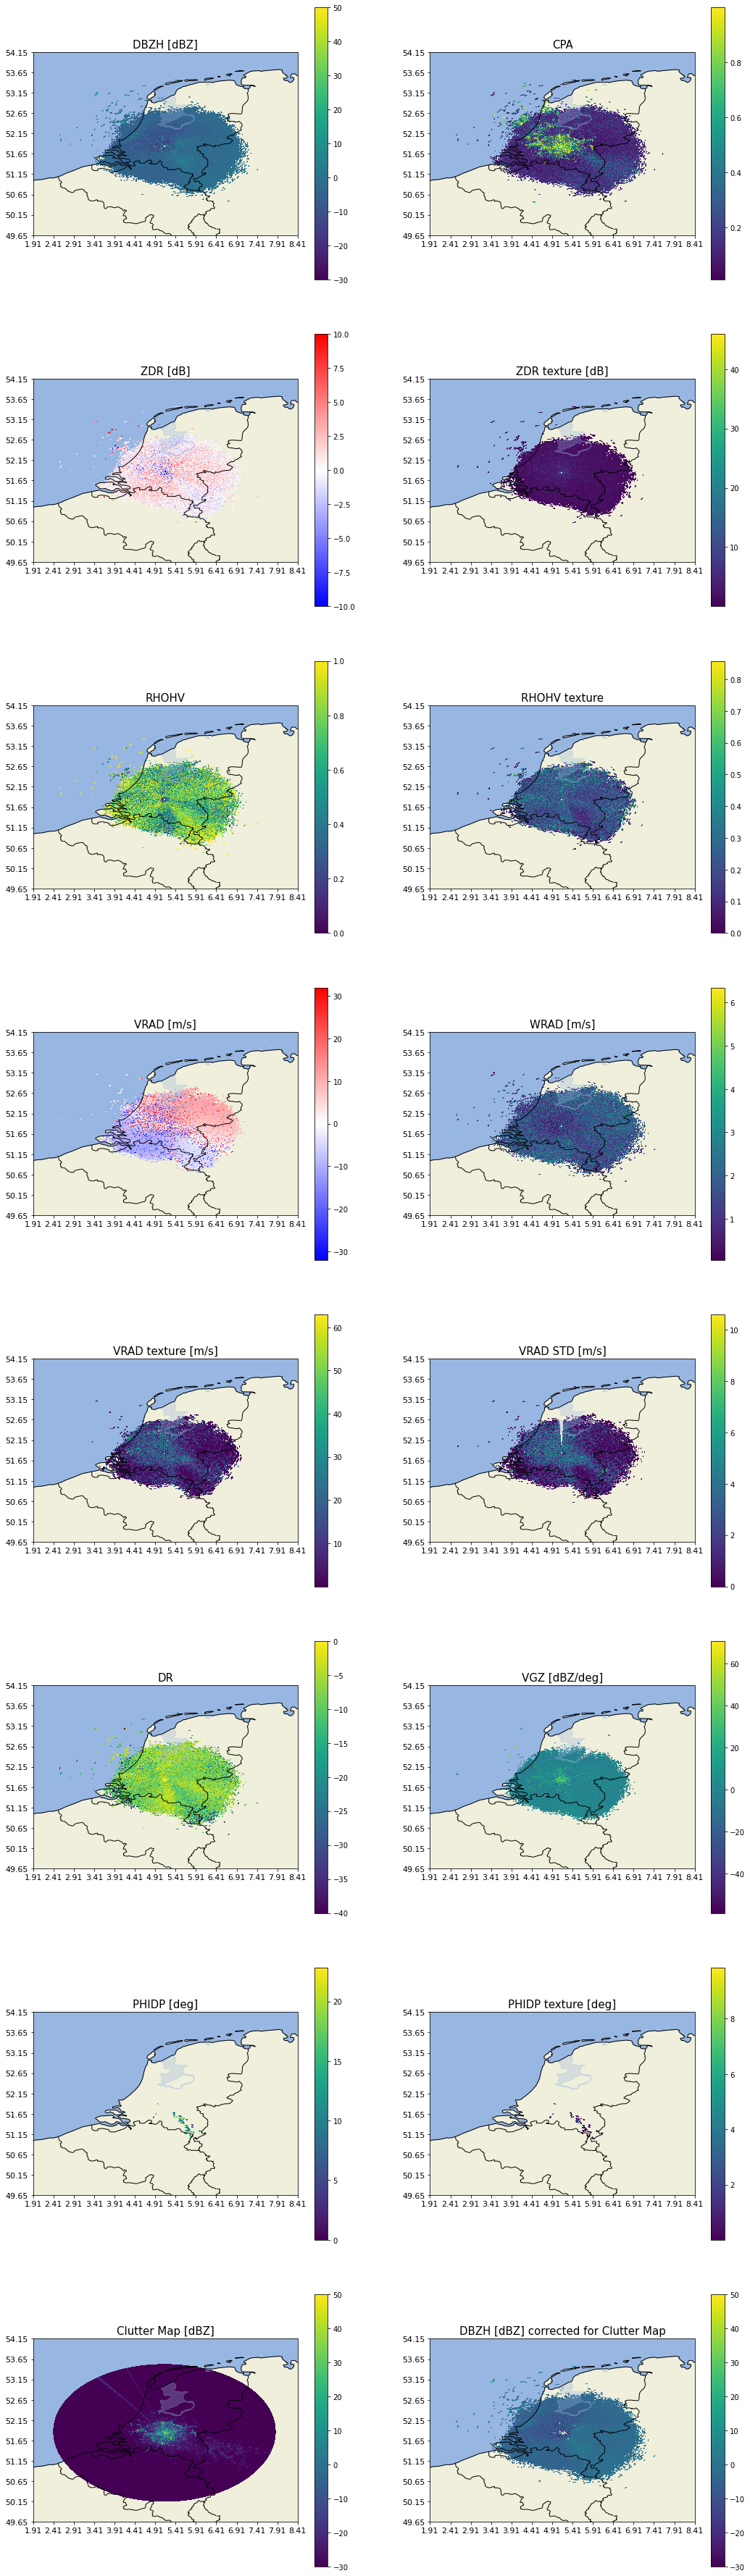

In [14]:
### Plot radae variables for biological targets
plt.figure(figsize=(18,65))

cmap = plt.get_cmap()

### DBZH
ax = plt.subplot(821, projection=ccrs.PlateCarree())
im = ax.pcolormesh(rad_lon, rad_lat, DBZH_b, cmap=cmap, vmin=-30, vmax=50)
ax.set_title('DBZH [dBZ]', fontsize= 15)
plt.colorbar(im, ax=ax)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES,alpha=0.3)
ax.set_yticks(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2))
ax.set_xticks(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2))
ax.set_yticklabels(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2), fontsize = 11)
ax.set_xticklabels(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2), fontsize = 11)

### CPA
ax = plt.subplot(822, projection=ccrs.PlateCarree())
im = ax.pcolormesh(rad_lon, rad_lat, CPA_b, cmap=cmap)#, vmin=-20, vmax=20)
ax.set_title('CPA', fontsize= 15)
plt.colorbar(im, ax=ax)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES,alpha=0.3)
ax.set_yticks(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2))
ax.set_xticks(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2))
ax.set_yticklabels(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2), fontsize = 11)
ax.set_xticklabels(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2), fontsize = 11)

### ZDR
ax = plt.subplot(823, projection=ccrs.PlateCarree())
im = ax.pcolormesh(rad_lon, rad_lat, ZDR_b, cmap='bwr', vmin=-10, vmax=10)
plt.colorbar(im, ax=ax)
ax.set_title('ZDR [dB]', fontsize= 15)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES,alpha=0.3)
ax.set_yticks(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2))
ax.set_xticks(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2))
ax.set_yticklabels(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2), fontsize = 11)
ax.set_xticklabels(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2), fontsize = 11)

### ZDR texture
ax = plt.subplot(824, projection=ccrs.PlateCarree())
im = ax.pcolormesh(rad_lon, rad_lat, ZDR_tex_b, cmap=cmap) #, vmin=-10, vmax=10)
plt.colorbar(im, ax=ax)
ax.set_title('ZDR texture [dB]', fontsize= 15)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES,alpha=0.3)
ax.set_yticks(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2))
ax.set_xticks(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2))
ax.set_yticklabels(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2), fontsize = 11)
ax.set_xticklabels(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2), fontsize = 11)

### RHOHV
ax = plt.subplot(825, projection=ccrs.PlateCarree())
im = ax.pcolormesh(rad_lon, rad_lat, RHOHV_b, cmap=cmap, vmin=0, vmax=1)
plt.colorbar(im, ax=ax)
ax.set_title('RHOHV', fontsize= 15)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES,alpha=0.3)
ax.set_yticks(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2))
ax.set_xticks(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2))
ax.set_yticklabels(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2), fontsize = 11)
ax.set_xticklabels(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2), fontsize = 11)

### RHOHV texture
ax = plt.subplot(826, projection=ccrs.PlateCarree())
im = ax.pcolormesh(rad_lon, rad_lat, RHOHV_tex_b, cmap=cmap) #, vmin=0, vmax=1)
plt.colorbar(im, ax=ax)
ax.set_title('RHOHV texture', fontsize= 15)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES,alpha=0.3)
ax.set_yticks(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2))
ax.set_xticks(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2))
ax.set_yticklabels(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2), fontsize = 11)
ax.set_xticklabels(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2), fontsize = 11)

### VRAD
ax = plt.subplot(827, projection=ccrs.PlateCarree())
im = ax.pcolormesh(rad_lon, rad_lat, VRAD_b, cmap='bwr') #, vmin=-20, vmax=20)
plt.colorbar(im, ax=ax)
ax.set_title('VRAD [m/s]', fontsize= 15)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES,alpha=0.3)
ax.set_yticks(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2))
ax.set_xticks(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2))
ax.set_yticklabels(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2), fontsize = 11)
ax.set_xticklabels(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2), fontsize = 11)

### WRAD
ax = plt.subplot(828, projection=ccrs.PlateCarree())
im = ax.pcolormesh(rad_lon, rad_lat, WRAD_b, cmap=cmap) #, vmin=-10, vmax=10)
plt.colorbar(im, ax=ax)
ax.set_title('WRAD [m/s]', fontsize= 15)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES,alpha=0.3)
ax.set_yticks(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2))
ax.set_xticks(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2))
ax.set_yticklabels(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2), fontsize = 11)
ax.set_xticklabels(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2), fontsize = 11)

### VRAD texture
ax = plt.subplot(829, projection=ccrs.PlateCarree())
im = ax.pcolormesh(rad_lon, rad_lat, VRAD_tex_b, cmap=cmap) #, vmin=0, vmax=10)
plt.colorbar(im, ax=ax)
ax.set_title('VRAD texture [m/s]', fontsize= 15)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES,alpha=0.3)
ax.set_yticks(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2))
ax.set_xticks(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2))
ax.set_yticklabels(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2), fontsize = 11)
ax.set_xticklabels(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2), fontsize = 11)

### VRAD STD
ax = plt.subplot(8,2,10, projection=ccrs.PlateCarree())
im = ax.pcolormesh(rad_lon, rad_lat, VRAD_std_b, cmap=cmap) #, vmin=0, vmax=5)
plt.colorbar(im, ax=ax)
ax.set_title('VRAD STD [m/s]', fontsize= 15)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES,alpha=0.3)
ax.set_yticks(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2))
ax.set_xticks(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2))
ax.set_yticklabels(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2), fontsize = 11)
ax.set_xticklabels(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2), fontsize = 11)

## DR
ax = plt.subplot(8,2,11, projection=ccrs.PlateCarree())
im = ax.pcolormesh(rad_lon, rad_lat, DR_b, cmap=cmap, vmin=-40, vmax=0)
plt.colorbar(im, ax=ax)
ax.set_title('DR',fontsize= 15)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES,alpha=0.3)
ax.set_yticks(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2))
ax.set_xticks(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2))
ax.set_yticklabels(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2), fontsize = 11)
ax.set_xticklabels(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2), fontsize = 11)

### VGZ
ax = plt.subplot(8,2,12, projection=ccrs.PlateCarree())
im = ax.pcolormesh(rad_lon, rad_lat, VGZ_b, cmap=cmap) #, vmin=-30, vmax=60)
plt.colorbar(im, ax=ax)
ax.set_title('VGZ [dBZ/deg]', fontsize= 15)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES,alpha=0.3)
ax.set_yticks(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2))
ax.set_xticks(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2))
ax.set_yticklabels(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2), fontsize = 11)
ax.set_xticklabels(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2), fontsize = 11)

### PHIDP
ax = plt.subplot(8,2,13, projection=ccrs.PlateCarree())
im = ax.pcolormesh(rad_lon, rad_lat, PHIDP_b, cmap=cmap) #, vmin=0, vmax=360)
plt.colorbar(im, ax=ax)
ax.set_title('PHIDP [deg]', fontsize= 15)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES,alpha=0.3)
ax.set_yticks(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2))
ax.set_xticks(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2))
ax.set_yticklabels(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2), fontsize = 11)
ax.set_xticklabels(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2), fontsize = 11)

### PHIDP texture
ax = plt.subplot(8,2,14, projection=ccrs.PlateCarree())
im = ax.pcolormesh(rad_lon, rad_lat, PHIDP_tex_b, cmap=cmap) #, vmin=0, vmax=360)
plt.colorbar(im, ax=ax)
ax.set_title('PHIDP texture [deg]', fontsize= 15)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES,alpha=0.3)
ax.set_yticks(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2))
ax.set_xticks(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2))
ax.set_yticklabels(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2), fontsize = 11)
ax.set_xticklabels(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2), fontsize = 11)

### clutter map
ax = plt.subplot(8,2,15, projection=ccrs.PlateCarree())
im = ax.pcolormesh(rad_lon, rad_lat, clu_map, cmap=cmap, vmin=-30, vmax=50)
ax.set_title('Clutter Map [dBZ]', fontsize= 15)
plt.colorbar(im, ax=ax)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES,alpha=0.3)
ax.set_yticks(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2))
ax.set_xticks(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2))
ax.set_yticklabels(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2), fontsize = 11)
ax.set_xticklabels(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2), fontsize = 11)

### DBZH without clutter
DBZH2 = np.copy(DBZH_b)
DBZH2[clu_map>=0]=np.nan
ax = plt.subplot(8,2,16, projection=ccrs.PlateCarree())
im = ax.pcolormesh(rad_lon, rad_lat, DBZH2, cmap=cmap, vmin=-30, vmax=50)
ax.set_title('DBZH [dBZ] corrected for Clutter Map', fontsize= 15)
plt.colorbar(im, ax=ax)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES,alpha=0.3)
ax.set_yticks(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2))
ax.set_xticks(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2))
ax.set_yticklabels(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2), fontsize = 11)
ax.set_xticklabels(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2), fontsize = 11)


### Save figure to OUT_PATH
OUT_PATH = "C:/Users/leona/Desktop/Plots/"
#plt.tight_layout()
#plt.savefig(OUT_PATH + 'case_bio_NLHRW_20190420_0040.png', facecolor='white')

#### 1.2) Precipitation

In [15]:
prec_path = "C:/Users/leona/Desktop/Data/precipitation/" #path to precipitation files
file = sorted(glob.glob(prec_path + 'NLHRW_pvol_20200218T2340_6356.h5'))  

radar = 'NLHRW'
dataset_idx = 6
map_date = '20190218'
map_var = 'TH'

radfile = file[0]
print(radfile)
f_p = OdimH5File(radfile)

DBZH_p, VGZ_p, ZDR_p, ZDR_tex_p, RHOHV_p, RHOHV_tex_p, DR_p, PHIDP_p, PHIDP_tex_p, KDP_p, VRAD_p, VRAD_tex_p, VRAD_std_p, WRAD_p, CPA_p, clu_map, rad_lat, rad_lon, RR, TT = extract_variables(f_p,radar,dataset_idx,map_date,map_var)

C:/Users/leona/Desktop/Data/precipitation/NLHRW_pvol_20200218T2340_6356.h5


C:\Users\leona\AppData\Local\Temp/ipykernel_5912/1637127489.py:5: RuntimeWarning: invalid value encountered in log10
  DR = 10*np.log10(Dr)


In [ ]:
plt.figure(figsize=(18,50))

cmap = plt.get_cmap()

### DBZH
ax = plt.subplot(721, projection=ccrs.PlateCarree())
im = ax.pcolormesh(rad_lon, rad_lat, DBZH_p, cmap=cmap) #, vmin=-30, vmax=60)
ax.set_title('DBZH [dBZ]', fontsize= 15)
plt.colorbar(im, ax=ax)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES,alpha=0.3)
ax.set_yticks(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2))
ax.set_xticks(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2))
ax.set_yticklabels(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2), fontsize = 11)
ax.set_xticklabels(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2), fontsize = 11)

### CPA
ax = plt.subplot(722, projection=ccrs.PlateCarree())
im = ax.pcolormesh(rad_lon, rad_lat, CPA_p, cmap=cmap)#, vmin=-20, vmax=20)
ax.set_title('CPA', fontsize= 15)
plt.colorbar(im, ax=ax)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES,alpha=0.3)
ax.set_yticks(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2))
ax.set_xticks(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2))
ax.set_yticklabels(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2), fontsize = 11)
ax.set_xticklabels(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2), fontsize = 11)

### ZDR
ax = plt.subplot(723, projection=ccrs.PlateCarree())
im = ax.pcolormesh(rad_lon, rad_lat, ZDR_p, cmap='bwr', vmin=-10, vmax=10)
plt.colorbar(im, ax=ax)
ax.set_title('ZDR [dB]', fontsize= 15)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES,alpha=0.3)
ax.set_yticks(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2))
ax.set_xticks(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2))
ax.set_yticklabels(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2), fontsize = 11)
ax.set_xticklabels(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2), fontsize = 11)

### ZDR texture
ax = plt.subplot(724, projection=ccrs.PlateCarree())
im = ax.pcolormesh(rad_lon, rad_lat, ZDR_tex_p, cmap=cmap) #, vmin=-10, vmax=10)
plt.colorbar(im, ax=ax)
ax.set_title('ZDR texture [dB]', fontsize= 15)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES,alpha=0.3)
ax.set_yticks(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2))
ax.set_xticks(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2))
ax.set_yticklabels(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2), fontsize = 11)
ax.set_xticklabels(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2), fontsize = 11)

### RHOHV
ax = plt.subplot(725, projection=ccrs.PlateCarree())
im = ax.pcolormesh(rad_lon, rad_lat, RHOHV_p, cmap=cmap, vmin=0, vmax=1)
plt.colorbar(im, ax=ax)
ax.set_title('RHOHV', fontsize= 15)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES,alpha=0.3)
ax.set_yticks(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2))
ax.set_xticks(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2))
ax.set_yticklabels(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2), fontsize = 11)
ax.set_xticklabels(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2), fontsize = 11)

### RHOHV texture
ax = plt.subplot(726, projection=ccrs.PlateCarree())
im = ax.pcolormesh(rad_lon, rad_lat, RHOHV_tex_p, cmap=cmap) #, vmin=0, vmax=1)
plt.colorbar(im, ax=ax)
ax.set_title('RHOHV texture', fontsize= 15)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES,alpha=0.3)
ax.set_yticks(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2))
ax.set_xticks(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2))
ax.set_yticklabels(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2), fontsize = 11)
ax.set_xticklabels(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2), fontsize = 11)

### VRAD
ax = plt.subplot(727, projection=ccrs.PlateCarree())
im = ax.pcolormesh(rad_lon, rad_lat, VRAD_p, cmap='bwr') #, vmin=-20, vmax=20)
plt.colorbar(im, ax=ax)
ax.set_title('VRAD [m/s]', fontsize= 15)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES,alpha=0.3)
ax.set_yticks(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2))
ax.set_xticks(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2))
ax.set_yticklabels(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2), fontsize = 11)
ax.set_xticklabels(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2), fontsize = 11)

### WRAD
ax = plt.subplot(728, projection=ccrs.PlateCarree())
im = ax.pcolormesh(rad_lon, rad_lat, WRAD_p, cmap=cmap) #, vmin=-10, vmax=10)
plt.colorbar(im, ax=ax)
ax.set_title('WRAD [m/s]', fontsize= 15)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES,alpha=0.3)
ax.set_yticks(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2))
ax.set_xticks(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2))
ax.set_yticklabels(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2), fontsize = 11)
ax.set_xticklabels(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2), fontsize = 11)

### VRAD texture
ax = plt.subplot(729, projection=ccrs.PlateCarree())
im = ax.pcolormesh(rad_lon, rad_lat, VRAD_tex_p, cmap=cmap) #, vmin=0, vmax=10)
plt.colorbar(im, ax=ax)
ax.set_title('VRAD texture [m/s]', fontsize= 15)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES,alpha=0.3)
ax.set_yticks(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2))
ax.set_xticks(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2))
ax.set_yticklabels(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2), fontsize = 11)
ax.set_xticklabels(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2), fontsize = 11)

### VRAD STD
ax = plt.subplot(7,2,10, projection=ccrs.PlateCarree())
im = ax.pcolormesh(rad_lon, rad_lat, VRAD_std_p, cmap=cmap) #, vmin=0, vmax=5)
plt.colorbar(im, ax=ax)
ax.set_title('VRAD STD [m/s]', fontsize= 15)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES,alpha=0.3)
ax.set_yticks(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2))
ax.set_xticks(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2))
ax.set_yticklabels(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2), fontsize = 11)
ax.set_xticklabels(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2), fontsize = 11)

## DR
ax = plt.subplot(7,2,11, projection=ccrs.PlateCarree())
im = ax.pcolormesh(rad_lon, rad_lat, DR_p, cmap=cmap, vmin=-40, vmax=0)
plt.colorbar(im, ax=ax)
ax.set_title('DR',fontsize= 15)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES,alpha=0.3)
ax.set_yticks(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2))
ax.set_xticks(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2))
ax.set_yticklabels(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2), fontsize = 11)
ax.set_xticklabels(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2), fontsize = 11)

### VGZ
ax = plt.subplot(7,2,12, projection=ccrs.PlateCarree())
im = ax.pcolormesh(rad_lon, rad_lat, VGZ_p, cmap=cmap) #, vmin=-30, vmax=60)
plt.colorbar(im, ax=ax)
ax.set_title('VGZ [dBZ/deg]', fontsize= 15)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES,alpha=0.3)
ax.set_yticks(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2))
ax.set_xticks(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2))
ax.set_yticklabels(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2), fontsize = 11)
ax.set_xticklabels(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2), fontsize = 11)

### PHIDP
ax = plt.subplot(7,2,13, projection=ccrs.PlateCarree())
im = ax.pcolormesh(rad_lon, rad_lat, PHIDP_p, cmap=cmap) #, vmin=0, vmax=360)
plt.colorbar(im, ax=ax)
ax.set_title('PHIDP [deg]', fontsize= 15)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES,alpha=0.3)
ax.set_yticks(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2))
ax.set_xticks(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2))
ax.set_yticklabels(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2), fontsize = 11)
ax.set_xticklabels(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2), fontsize = 11)

### PHIDP texture
ax = plt.subplot(7,2,14, projection=ccrs.PlateCarree())
im = ax.pcolormesh(rad_lon, rad_lat, PHIDP_tex_p, cmap=cmap) #, vmin=0, vmax=360)
plt.colorbar(im, ax=ax)
ax.set_title('PHIDP texture [deg]', fontsize= 15)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES,alpha=0.3)
ax.set_yticks(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2))
ax.set_xticks(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2))
ax.set_yticklabels(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2), fontsize = 11)
ax.set_xticklabels(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2), fontsize = 11)


### Save plots to OUT_PATH
OUT_PATH = "C:/Users/leona/Desktop/Plots/"
#plt.tight_layout()
#plt.savefig(OUT_PATH + 'case_prec_NLHRW_20200218_2340.png', facecolor='white')

#### 1.3) Clutter

In [17]:
clutter_path = "C:/Users/leona/Desktop/Data/clutter/"
file = sorted(glob.glob(clutter_path + 'NLHRW_pvol_20201124T0500_6356.h5'))  

radar = 'NLHRW'
dataset_idx = 6
map_date = '20190218'
map_var = 'TH'

radfile = file[0]
print(radfile)
f_c = OdimH5File(radfile)

DBZH_c, VGZ_c, ZDR_c, ZDR_tex_c, RHOHV_c, RHOHV_tex_c, DR_c, PHIDP_c, PHIDP_tex_c, KDP_c, VRAD_c, VRAD_tex_c, VRAD_std_c, WRAD_c, CPA_c, clu_map, rad_lat, rad_lon, RR, TT = extract_variables(f_c,radar,dataset_idx,map_date,map_var)

C:/Users/leona/Desktop/Data/clutter/NLHRW_pvol_20201124T0500_6356.h5


C:\Users\leona\AppData\Local\Temp/ipykernel_5912/1637127489.py:5: RuntimeWarning: invalid value encountered in log10
  DR = 10*np.log10(Dr)


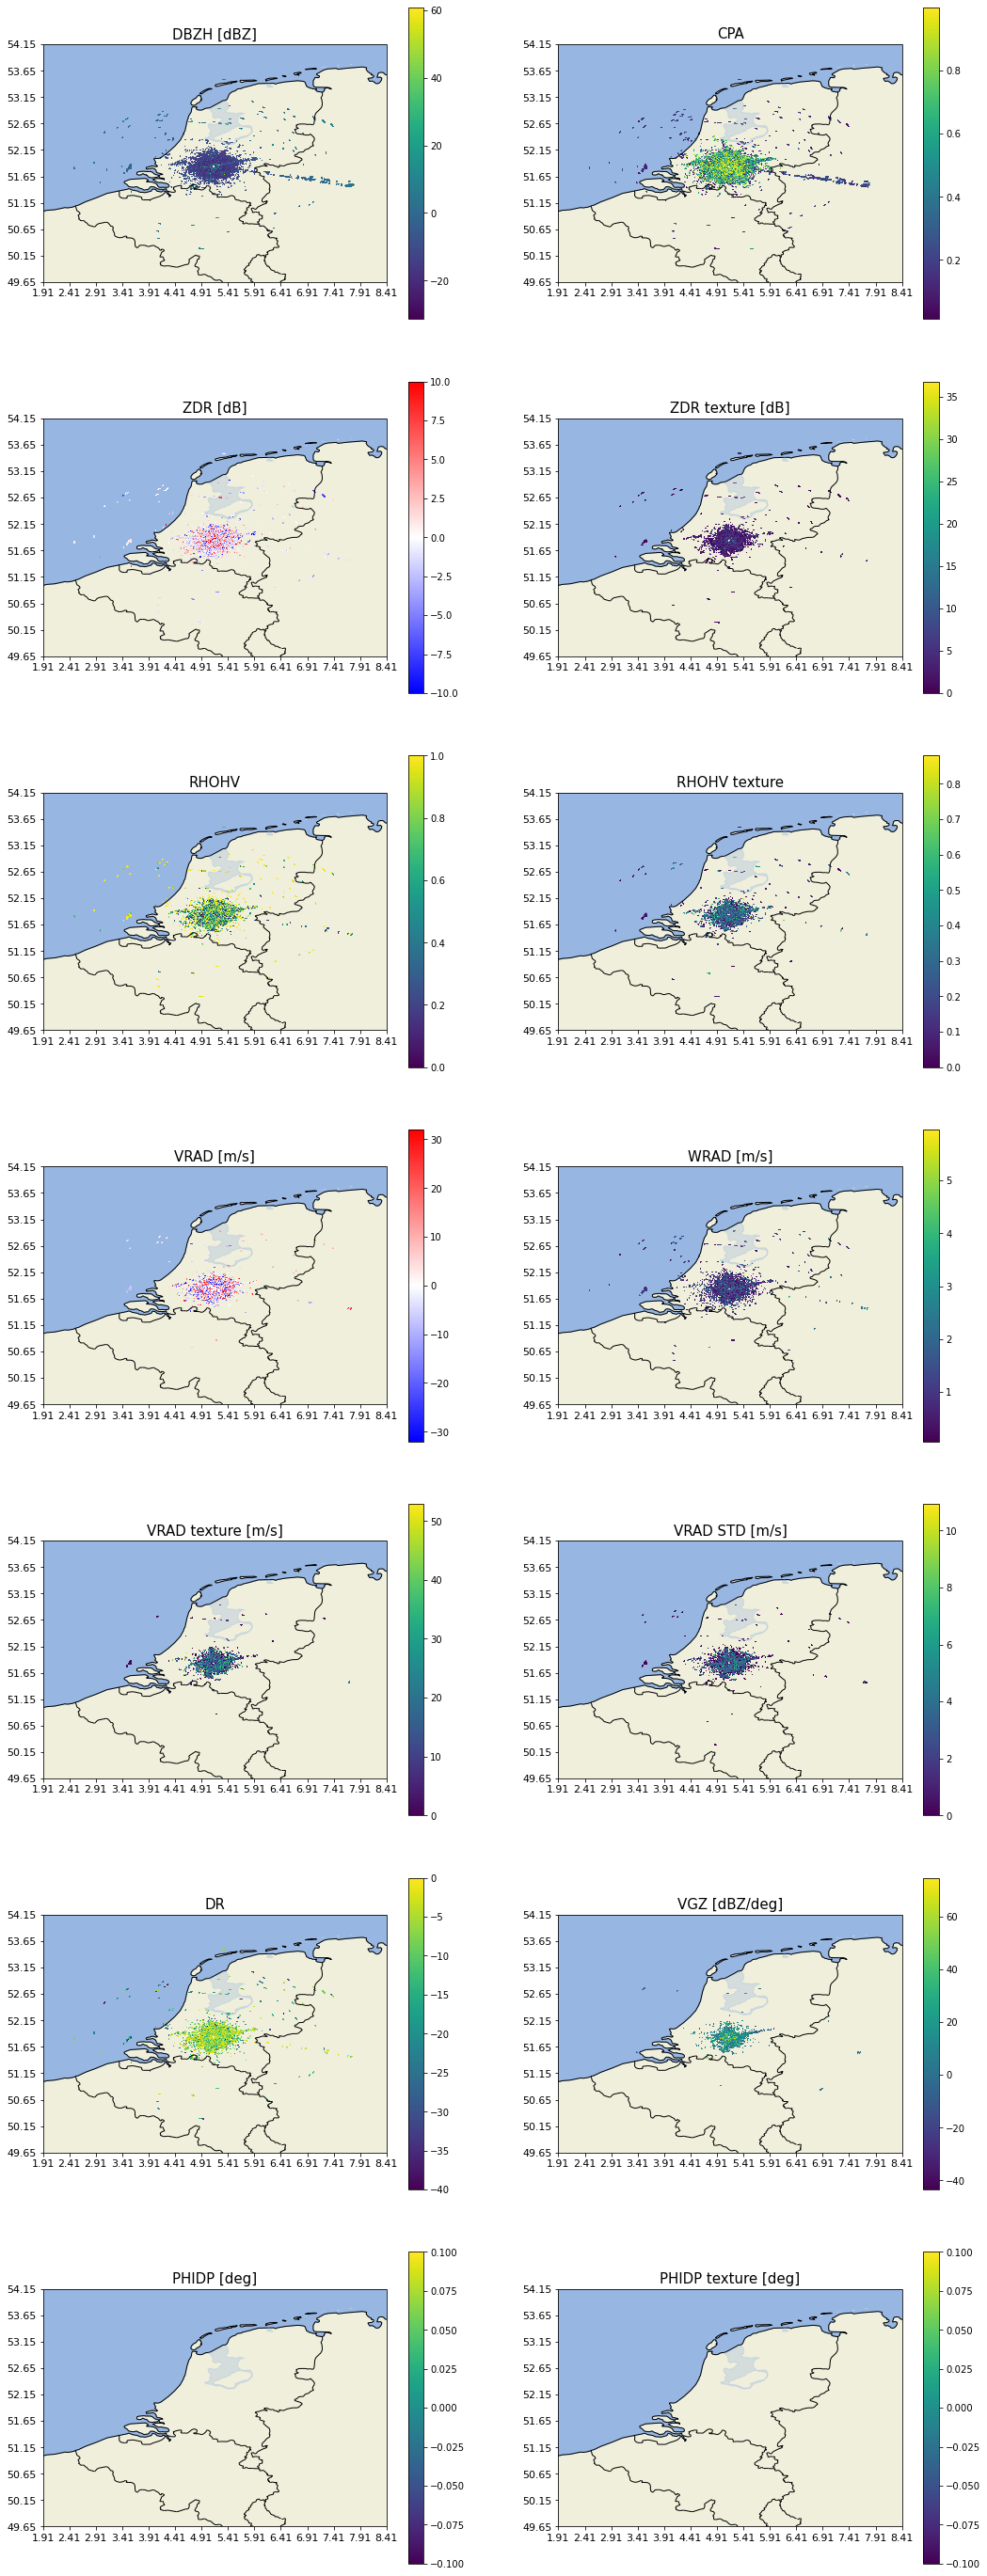

In [18]:
plt.figure(figsize=(18,50))

cmap = plt.get_cmap()

### DBZH
ax = plt.subplot(721, projection=ccrs.PlateCarree())
im = ax.pcolormesh(rad_lon, rad_lat, DBZH_c, cmap=cmap) #, vmin=-30, vmax=60)
ax.set_title('DBZH [dBZ]', fontsize= 15)
plt.colorbar(im, ax=ax)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES,alpha=0.3)
ax.set_yticks(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2))
ax.set_xticks(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2))
ax.set_yticklabels(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2), fontsize = 11)
ax.set_xticklabels(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2), fontsize = 11)

### CPA
ax = plt.subplot(722, projection=ccrs.PlateCarree())
im = ax.pcolormesh(rad_lon, rad_lat, CPA_c, cmap=cmap)#, vmin=-20, vmax=20)
ax.set_title('CPA', fontsize= 15)
plt.colorbar(im, ax=ax)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES,alpha=0.3)
ax.set_yticks(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2))
ax.set_xticks(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2))
ax.set_yticklabels(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2), fontsize = 11)
ax.set_xticklabels(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2), fontsize = 11)

### ZDR
ax = plt.subplot(723, projection=ccrs.PlateCarree())
im = ax.pcolormesh(rad_lon, rad_lat, ZDR_c, cmap='bwr', vmin=-10, vmax=10)
plt.colorbar(im, ax=ax)
ax.set_title('ZDR [dB]', fontsize= 15)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES,alpha=0.3)
ax.set_yticks(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2))
ax.set_xticks(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2))
ax.set_yticklabels(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2), fontsize = 11)
ax.set_xticklabels(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2), fontsize = 11)

### ZDR texture
ax = plt.subplot(724, projection=ccrs.PlateCarree())
im = ax.pcolormesh(rad_lon, rad_lat, ZDR_tex_c, cmap=cmap) #, vmin=-10, vmax=10)
plt.colorbar(im, ax=ax)
ax.set_title('ZDR texture [dB]', fontsize= 15)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES,alpha=0.3)
ax.set_yticks(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2))
ax.set_xticks(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2))
ax.set_yticklabels(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2), fontsize = 11)
ax.set_xticklabels(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2), fontsize = 11)

### RHOHV
ax = plt.subplot(725, projection=ccrs.PlateCarree())
im = ax.pcolormesh(rad_lon, rad_lat, RHOHV_c, cmap=cmap, vmin=0, vmax=1)
plt.colorbar(im, ax=ax)
ax.set_title('RHOHV', fontsize= 15)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES,alpha=0.3)
ax.set_yticks(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2))
ax.set_xticks(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2))
ax.set_yticklabels(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2), fontsize = 11)
ax.set_xticklabels(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2), fontsize = 11)

### RHOHV texture
ax = plt.subplot(726, projection=ccrs.PlateCarree())
im = ax.pcolormesh(rad_lon, rad_lat, RHOHV_tex_c, cmap=cmap) #, vmin=0, vmax=1)
plt.colorbar(im, ax=ax)
ax.set_title('RHOHV texture', fontsize= 15)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES,alpha=0.3)
ax.set_yticks(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2))
ax.set_xticks(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2))
ax.set_yticklabels(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2), fontsize = 11)
ax.set_xticklabels(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2), fontsize = 11)

### VRAD
ax = plt.subplot(727, projection=ccrs.PlateCarree())
im = ax.pcolormesh(rad_lon, rad_lat, VRAD_c, cmap='bwr') #, vmin=-20, vmax=20)
plt.colorbar(im, ax=ax)
ax.set_title('VRAD [m/s]', fontsize= 15)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES,alpha=0.3)
ax.set_yticks(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2))
ax.set_xticks(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2))
ax.set_yticklabels(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2), fontsize = 11)
ax.set_xticklabels(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2), fontsize = 11)

### WRAD
ax = plt.subplot(728, projection=ccrs.PlateCarree())
im = ax.pcolormesh(rad_lon, rad_lat, WRAD_c, cmap=cmap) #, vmin=-10, vmax=10)
plt.colorbar(im, ax=ax)
ax.set_title('WRAD [m/s]', fontsize= 15)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES,alpha=0.3)
ax.set_yticks(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2))
ax.set_xticks(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2))
ax.set_yticklabels(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2), fontsize = 11)
ax.set_xticklabels(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2), fontsize = 11)

### VRAD texture
ax = plt.subplot(729, projection=ccrs.PlateCarree())
im = ax.pcolormesh(rad_lon, rad_lat, VRAD_tex_c, cmap=cmap) #, vmin=0, vmax=10)
plt.colorbar(im, ax=ax)
ax.set_title('VRAD texture [m/s]', fontsize= 15)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES,alpha=0.3)
ax.set_yticks(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2))
ax.set_xticks(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2))
ax.set_yticklabels(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2), fontsize = 11)
ax.set_xticklabels(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2), fontsize = 11)

### VRAD STD
ax = plt.subplot(7,2,10, projection=ccrs.PlateCarree())
im = ax.pcolormesh(rad_lon, rad_lat, VRAD_std_c, cmap=cmap) #, vmin=0, vmax=5)
plt.colorbar(im, ax=ax)
ax.set_title('VRAD STD [m/s]', fontsize= 15)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES,alpha=0.3)
ax.set_yticks(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2))
ax.set_xticks(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2))
ax.set_yticklabels(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2), fontsize = 11)
ax.set_xticklabels(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2), fontsize = 11)

## DR
ax = plt.subplot(7,2,11, projection=ccrs.PlateCarree())
im = ax.pcolormesh(rad_lon, rad_lat, DR_c, cmap=cmap, vmin=-40, vmax=0)
plt.colorbar(im, ax=ax)
ax.set_title('DR',fontsize= 15)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES,alpha=0.3)
ax.set_yticks(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2))
ax.set_xticks(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2))
ax.set_yticklabels(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2), fontsize = 11)
ax.set_xticklabels(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2), fontsize = 11)

### VGZ
ax = plt.subplot(7,2,12, projection=ccrs.PlateCarree())
im = ax.pcolormesh(rad_lon, rad_lat, VGZ_c, cmap=cmap) #, vmin=-30, vmax=60)
plt.colorbar(im, ax=ax)
ax.set_title('VGZ [dBZ/deg]', fontsize= 15)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES,alpha=0.3)
ax.set_yticks(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2))
ax.set_xticks(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2))
ax.set_yticklabels(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2), fontsize = 11)
ax.set_xticklabels(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2), fontsize = 11)

### PHIDP
ax = plt.subplot(7,2,13, projection=ccrs.PlateCarree())
im = ax.pcolormesh(rad_lon, rad_lat, PHIDP_c, cmap=cmap) #, vmin=0, vmax=360)
plt.colorbar(im, ax=ax)
ax.set_title('PHIDP [deg]', fontsize= 15)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES,alpha=0.3)
ax.set_yticks(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2))
ax.set_xticks(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2))
ax.set_yticklabels(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2), fontsize = 11)
ax.set_xticklabels(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2), fontsize = 11)

### PHIDP texture
ax = plt.subplot(7,2,14, projection=ccrs.PlateCarree())
im = ax.pcolormesh(rad_lon, rad_lat, PHIDP_tex_c, cmap=cmap) #, vmin=0, vmax=360)
plt.colorbar(im, ax=ax)
ax.set_title('PHIDP texture [deg]', fontsize= 15)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES,alpha=0.3)
ax.set_yticks(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2))
ax.set_xticks(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2))
ax.set_yticklabels(np.round(np.arange(np.nanmin(rad_lat)-0.5, np.nanmax(rad_lat)+1, 0.5),2), fontsize = 11)
ax.set_xticklabels(np.round(np.arange(np.nanmin(rad_lon)-0.5, np.nanmax(rad_lon)+1, 0.5),2), fontsize = 11)


### Save plots to OUT_PATH
OUT_PATH = "C:/Users/leona/Desktop/Plots/"
#plt.tight_layout()
#plt.savefig(OUT_PATH + 'case_clu_NLHRW_20201124_0500.png', facecolor='white')

### 2) Extract data for each class from multiple cases and save to CSV files

- Skip this part and go to directly to 4) if you want to use just one file for each class, data extracted in 1)
- Skip this part and go to 3) if you already saved data from each class in CSV files and you want just to load them

#### 2.1) biological targets

In [45]:
### Add header and create a new file CSV file
with open('bio_data.csv', 'w', newline='') as outcsv:
    writer = csv.writer(outcsv)
    writer.writerow(['DBZH','VGZ','ZDR','ZDR_tex','RHOHV','RHOHV_tex', 'DR',
                     'PHIDP','PHIDP_tex','KDP',
                     'VRAD','VRAD_tex','VRAD_std','WRAD',
                     'CPA','clutter_map',
                     'rad_lon','rad_lat','range','azimuth'])

In [46]:
### Files for biological targets
files = sorted(glob.glob(bio_path + '*.h5'))  
print(len(files))

6


In [47]:
### This is for clutter map
radar = 'NLHRW'
dataset_idx = 6
map_date = '20190218'
map_var = 'TH'

### Here starts extraction of data
start_t = time.time()
count = 0

for radfile in files:
    print(radfile)
    count = count+1
    print('file ',count,': ', radfile)
    
    f_o = OdimH5File(radfile)

    for dataset_idx in [6]:
        print('dataset',dataset_idx)
        
        DBZH, VGZ, ZDR, ZDR_tex, RHOHV, RHOHV_tex, DR, PHIDP, PHIDP_tex, KDP, VRAD, VRAD_tex, VRAD_std, WRAD, CPA, clu_map, rad_lat, rad_lon, RR, TT = extract_variables(f_o,radar,dataset_idx,map_date,map_var)
        
        my_array = [DBZH.flatten(), VGZ.flatten(), ZDR.flatten(), ZDR_tex.flatten(),
                    RHOHV.flatten(), RHOHV_tex.flatten(), DR.flatten(), 
                    PHIDP.flatten(), PHIDP_tex.flatten(), KDP.flatten(), 
                    VRAD.flatten(), VRAD_tex.flatten(), VRAD_std.flatten(), WRAD.flatten(),
                    CPA.flatten(), clu_map.flatten(), 
                    rad_lat.flatten(), rad_lon.flatten(), RR.flatten(), TT.flatten()]
        my_array = np.transpose(my_array)

        with open('bio_data.csv', 'a') as f:
            np.savetxt(f, my_array, delimiter=',', fmt='%s')

        del my_array, DBZH, VGZ, ZDR, ZDR_tex, RHOHV, RHOHV_tex, PHIDP, PHIDP_tex, KDP, VRAD, VRAD_tex, VRAD_std, WRAD, DR, clu_map, rad_lon, rad_lat, RR, TT
    
    
    f_o.close()

end_t = time.time()

# total time taken
print(f"Runtime of the program is {end_t - start_t}")

/media/leo/Extreme SSD/fuzzy/bio/NLHRW_pvol_20190420T0025_6356.h5
file  1 :  /media/leo/Extreme SSD/fuzzy/bio/NLHRW_pvol_20190420T0025_6356.h5
dataset 6


<ipython-input-10-4072cfe95759>:5: RuntimeWarning: invalid value encountered in log10
  DR = 10*np.log10(Dr)


/media/leo/Extreme SSD/fuzzy/bio/NLHRW_pvol_20190420T0030_6356.h5
file  2 :  /media/leo/Extreme SSD/fuzzy/bio/NLHRW_pvol_20190420T0030_6356.h5
dataset 6
/media/leo/Extreme SSD/fuzzy/bio/NLHRW_pvol_20190420T0035_6356.h5
file  3 :  /media/leo/Extreme SSD/fuzzy/bio/NLHRW_pvol_20190420T0035_6356.h5
dataset 6
/media/leo/Extreme SSD/fuzzy/bio/NLHRW_pvol_20190420T0040_6356.h5
file  4 :  /media/leo/Extreme SSD/fuzzy/bio/NLHRW_pvol_20190420T0040_6356.h5
dataset 6
/media/leo/Extreme SSD/fuzzy/bio/NLHRW_pvol_20190420T0045_6356.h5
file  5 :  /media/leo/Extreme SSD/fuzzy/bio/NLHRW_pvol_20190420T0045_6356.h5
dataset 6
/media/leo/Extreme SSD/fuzzy/bio/NLHRW_pvol_20190420T0050_6356.h5
file  6 :  /media/leo/Extreme SSD/fuzzy/bio/NLHRW_pvol_20190420T0050_6356.h5
dataset 6
Runtime of the program is 84.61844849586487


#### 2.2) precipitation

In [48]:
### Add header and create a new CSV file
with open('precipitation_data.csv', 'w', newline='') as outcsv:
    writer = csv.writer(outcsv)
    writer.writerow(['DBZH','VGZ','ZDR','ZDR_tex','RHOHV','RHOHV_tex', 'DR',
                     'PHIDP','PHIDP_tex','KDP',
                     'VRAD','VRAD_tex','VRAD_std','WRAD',
                     'CPA','clutter_map',
                     'rad_lon','rad_lat','range','azimuth'])

In [51]:
files = sorted(glob.glob(prec_path + '*.h5'))  
print(len(files))

6


In [53]:
radar = 'NLHRW'
dataset_idx = 6
map_date = '20190218'
map_var = 'TH'

start_t = time.time()
count = 0

for radfile in files:
    print(radfile)
    count = count+1
    print('file ',count,': ', radfile)
    
    f_o = OdimH5File(radfile)

    for dataset_idx in [6]:
        print('dataset',dataset_idx)
        
        DBZH, VGZ, ZDR, ZDR_tex, RHOHV, RHOHV_tex, DR, PHIDP, PHIDP_tex, KDP, VRAD, VRAD_tex, VRAD_std, WRAD, CPA, clu_map, rad_lat, rad_lon, RR, TT = extract_variables(f_o,radar,dataset_idx,map_date,map_var)
        
        my_array = [DBZH.flatten(), VGZ.flatten(), ZDR.flatten(), ZDR_tex.flatten(),
                    RHOHV.flatten(), RHOHV_tex.flatten(), DR.flatten(), 
                    PHIDP.flatten(), PHIDP_tex.flatten(), KDP.flatten(), 
                    VRAD.flatten(), VRAD_tex.flatten(), VRAD_std.flatten(), WRAD.flatten(),
                    CPA.flatten(), clu_map.flatten(), 
                    rad_lat.flatten(), rad_lon.flatten(), RR.flatten(), TT.flatten()]
        my_array = np.transpose(my_array)

        with open('precipitation_data.csv', 'a') as f:
            np.savetxt(f, my_array, delimiter=',', fmt='%s')

        del my_array, DBZH, VGZ, ZDR, ZDR_tex, RHOHV, RHOHV_tex, PHIDP, PHIDP_tex, KDP, VRAD, VRAD_tex, VRAD_std, WRAD, DR, clu_map, rad_lon, rad_lat, RR, TT
    
    
    f_o.close()

end_t = time.time()

# total time taken
print(f"Runtime of the program is {end_t - start_t}")

/media/leo/Extreme SSD/fuzzy/precipitation/NLHRW_pvol_20200218T2330_6356.h5
file  1 :  /media/leo/Extreme SSD/fuzzy/precipitation/NLHRW_pvol_20200218T2330_6356.h5
dataset 6


<ipython-input-10-4072cfe95759>:5: RuntimeWarning: invalid value encountered in log10
  DR = 10*np.log10(Dr)


/media/leo/Extreme SSD/fuzzy/precipitation/NLHRW_pvol_20200218T2335_6356.h5
file  2 :  /media/leo/Extreme SSD/fuzzy/precipitation/NLHRW_pvol_20200218T2335_6356.h5
dataset 6
/media/leo/Extreme SSD/fuzzy/precipitation/NLHRW_pvol_20200218T2340_6356.h5
file  3 :  /media/leo/Extreme SSD/fuzzy/precipitation/NLHRW_pvol_20200218T2340_6356.h5
dataset 6
/media/leo/Extreme SSD/fuzzy/precipitation/NLHRW_pvol_20200218T2345_6356.h5
file  4 :  /media/leo/Extreme SSD/fuzzy/precipitation/NLHRW_pvol_20200218T2345_6356.h5
dataset 6
/media/leo/Extreme SSD/fuzzy/precipitation/NLHRW_pvol_20200218T2350_6356.h5
file  5 :  /media/leo/Extreme SSD/fuzzy/precipitation/NLHRW_pvol_20200218T2350_6356.h5
dataset 6
/media/leo/Extreme SSD/fuzzy/precipitation/NLHRW_pvol_20200218T2355_6356.h5
file  6 :  /media/leo/Extreme SSD/fuzzy/precipitation/NLHRW_pvol_20200218T2355_6356.h5
dataset 6
Runtime of the program is 117.66265845298767


#### 2.3) clutter 

In [54]:
### Add header and create a new CSV file
with open('clutter_data.csv', 'w', newline='') as outcsv:
    writer = csv.writer(outcsv)
    writer.writerow(['DBZH','VGZ','ZDR','ZDR_tex','RHOHV','RHOHV_tex', 'DR',
                     'PHIDP','PHIDP_tex','KDP',
                     'VRAD','VRAD_tex','VRAD_std','WRAD',
                     'CPA','clutter_map',
                     'rad_lon','rad_lat','range','azimuth'])

In [57]:
files = sorted(glob.glob(clutter_path + '*.h5'))  
print(len(files))

6


In [58]:
radar = 'NLHRW'
dataset_idx = 6
map_date = '20190218'
map_var = 'TH'

start_t = time.time()
count = 0

for radfile in files:
    print(radfile)
    count = count+1
    print('file ',count,': ', radfile)
    
    f_o = OdimH5File(radfile)

    for dataset_idx in [6]:
        print('dataset',dataset_idx)
        
        DBZH, VGZ, ZDR, ZDR_tex, RHOHV, RHOHV_tex, DR, PHIDP, PHIDP_tex, KDP, VRAD, VRAD_tex, VRAD_std, WRAD, CPA, clu_map, rad_lat, rad_lon, RR, TT = extract_variables(f_o,radar,dataset_idx,map_date,map_var)
        
        my_array = [DBZH.flatten(), VGZ.flatten(), ZDR.flatten(), ZDR_tex.flatten(),
                    RHOHV.flatten(), RHOHV_tex.flatten(), DR.flatten(), 
                    PHIDP.flatten(), PHIDP_tex.flatten(), KDP.flatten(), 
                    VRAD.flatten(), VRAD_tex.flatten(), VRAD_std.flatten(), WRAD.flatten(),
                    CPA.flatten(), clu_map.flatten(), 
                    rad_lat.flatten(), rad_lon.flatten(),RR.flatten(),TT.flatten()]
        my_array = np.transpose(my_array)

        with open('clutter_data.csv', 'a') as f:
            np.savetxt(f, my_array, delimiter=',', fmt='%s')

        del my_array, DBZH, VGZ, ZDR, ZDR_tex, RHOHV, RHOHV_tex, PHIDP, PHIDP_tex, KDP, VRAD, VRAD_tex, VRAD_std, WRAD, DR, clu_map, rad_lon, rad_lat, RR, TT
    
    
    f_o.close()

end_t = time.time()

# total time taken
print(f"Runtime of the program is {end_t - start_t}")

/media/leo/Extreme SSD/fuzzy/clutter/NLHRW_pvol_20201124T0450_6356.h5
file  1 :  /media/leo/Extreme SSD/fuzzy/clutter/NLHRW_pvol_20201124T0450_6356.h5
dataset 6


<ipython-input-10-4072cfe95759>:5: RuntimeWarning: invalid value encountered in log10
  DR = 10*np.log10(Dr)


/media/leo/Extreme SSD/fuzzy/clutter/NLHRW_pvol_20201124T0455_6356.h5
file  2 :  /media/leo/Extreme SSD/fuzzy/clutter/NLHRW_pvol_20201124T0455_6356.h5
dataset 6
/media/leo/Extreme SSD/fuzzy/clutter/NLHRW_pvol_20201124T0500_6356.h5
file  3 :  /media/leo/Extreme SSD/fuzzy/clutter/NLHRW_pvol_20201124T0500_6356.h5
dataset 6
/media/leo/Extreme SSD/fuzzy/clutter/NLHRW_pvol_20201124T0505_6356.h5
file  4 :  /media/leo/Extreme SSD/fuzzy/clutter/NLHRW_pvol_20201124T0505_6356.h5
dataset 6
/media/leo/Extreme SSD/fuzzy/clutter/NLHRW_pvol_20201124T0510_6356.h5
file  5 :  /media/leo/Extreme SSD/fuzzy/clutter/NLHRW_pvol_20201124T0510_6356.h5
dataset 6
/media/leo/Extreme SSD/fuzzy/clutter/NLHRW_pvol_20201124T0515_6356.h5
file  6 :  /media/leo/Extreme SSD/fuzzy/clutter/NLHRW_pvol_20201124T0515_6356.h5
dataset 6
Runtime of the program is 60.62034893035889


### 3) Load data for each class already saved in CSV files

In [20]:
DATA_PATH = "C:/Users/leona/Desktop/Data/"

dataa_b = pd.read_csv(DATA_PATH + 'bio_data.csv')
dataa_p = pd.read_csv(DATA_PATH + 'precipitation_data.csv')
dataa_c = pd.read_csv(DATA_PATH + 'clutter_data.csv')

print(dataa_b)

              DBZH       VGZ        ZDR    ZDR_tex     RHOHV  RHOHV_tex  \
0        13.708069 -1.218743 -21.885043  39.711409  0.167120   0.093689   
1        19.744721 -1.281187  26.737620  29.242816  0.092975   0.239519   
2        26.095318  0.258391  32.299479   7.076790  0.089969   0.290898   
3        33.176514  1.358704  36.248981  15.342596  0.020173   0.334167   
4         9.411678  2.575294  13.999606  11.670486  0.245003   0.164506   
...            ...       ...        ...        ...       ...        ...   
1810075        NaN       NaN        NaN        NaN       NaN        NaN   
1810076        NaN       NaN        NaN        NaN       NaN        NaN   
1810077        NaN       NaN        NaN        NaN       NaN        NaN   
1810078        NaN       NaN        NaN        NaN       NaN        NaN   
1810079        NaN       NaN        NaN        NaN       NaN        NaN   

               DR  PHIDP  PHIDP_tex  KDP  VRAD  VRAD_tex  VRAD_std  WRAD  \
0       -0.232230    Na

#### 3.1) biological targets

In [21]:
clu_map_b = dataa_b['clutter_map']
DBZH_b = dataa_b['DBZH']
VGZ_b = dataa_b['VGZ']
ZDR_b = dataa_b['ZDR']
ZDR_tex_b = dataa_b['ZDR_tex']
RHOHV_b = dataa_b['RHOHV']
RHOHV_tex_b = dataa_b['RHOHV_tex']
DR_b = dataa_b['DR']
PHIDP_b = dataa_b['PHIDP']
PHIDP_tex_b = dataa_b['PHIDP_tex']
KDP_b = dataa_b['KDP']
VRAD_b = dataa_b['VRAD']
VRAD_tex_b = dataa_b['VRAD_tex']
VRAD_std_b = dataa_b['VRAD_std']
WRAD_b = dataa_b['WRAD']
WRAD_b = dataa_b['WRAD']
CPA_b = dataa_b['CPA']
R_b = dataa_b['range']

#### 3.2) precipitation

In [22]:
clu_map_p = dataa_p['clutter_map']
DBZH_p = dataa_p['DBZH']
VGZ_p = dataa_p['VGZ']
ZDR_p = dataa_p['ZDR']
ZDR_tex_p = dataa_p['ZDR_tex']
RHOHV_p = dataa_p['RHOHV']
RHOHV_tex_p = dataa_p['RHOHV_tex']
DR_p = dataa_p['DR']
PHIDP_p = dataa_p['PHIDP']
PHIDP_tex_p = dataa_p['PHIDP_tex']
KDP_p = dataa_p['KDP']
VRAD_p = dataa_p['VRAD']
VRAD_tex_p = dataa_p['VRAD_tex']
VRAD_std_p = dataa_p['VRAD_std']
WRAD_p = dataa_p['WRAD']
CPA_p = dataa_p['CPA']
R_p = dataa_p['range']

#### 3.3) clutter

In [23]:
clu_map_c = dataa_c['clutter_map']
DBZH_c = dataa_c['DBZH']
VGZ_c = dataa_c['VGZ']
ZDR_c = dataa_c['ZDR']
ZDR_tex_c = dataa_c['ZDR_tex']
RHOHV_c = dataa_c['RHOHV']
RHOHV_tex_c = dataa_c['RHOHV_tex']
DR_c = dataa_c['DR']
PHIDP_c = dataa_c['PHIDP']
PHIDP_tex_c = dataa_c['PHIDP_tex']
KDP_c = dataa_c['KDP']
VRAD_c = dataa_c['VRAD']
VRAD_tex_c = dataa_c['VRAD_tex']
VRAD_std_c = dataa_c['VRAD_std']
WRAD_c = dataa_c['WRAD']
CPA_c = dataa_c['CPA']
R_c = dataa_c['range'] 

### 4) Analysis starts here, I have all the data I need for each group

#### Scatterplot to see the contribution of VRAD STD

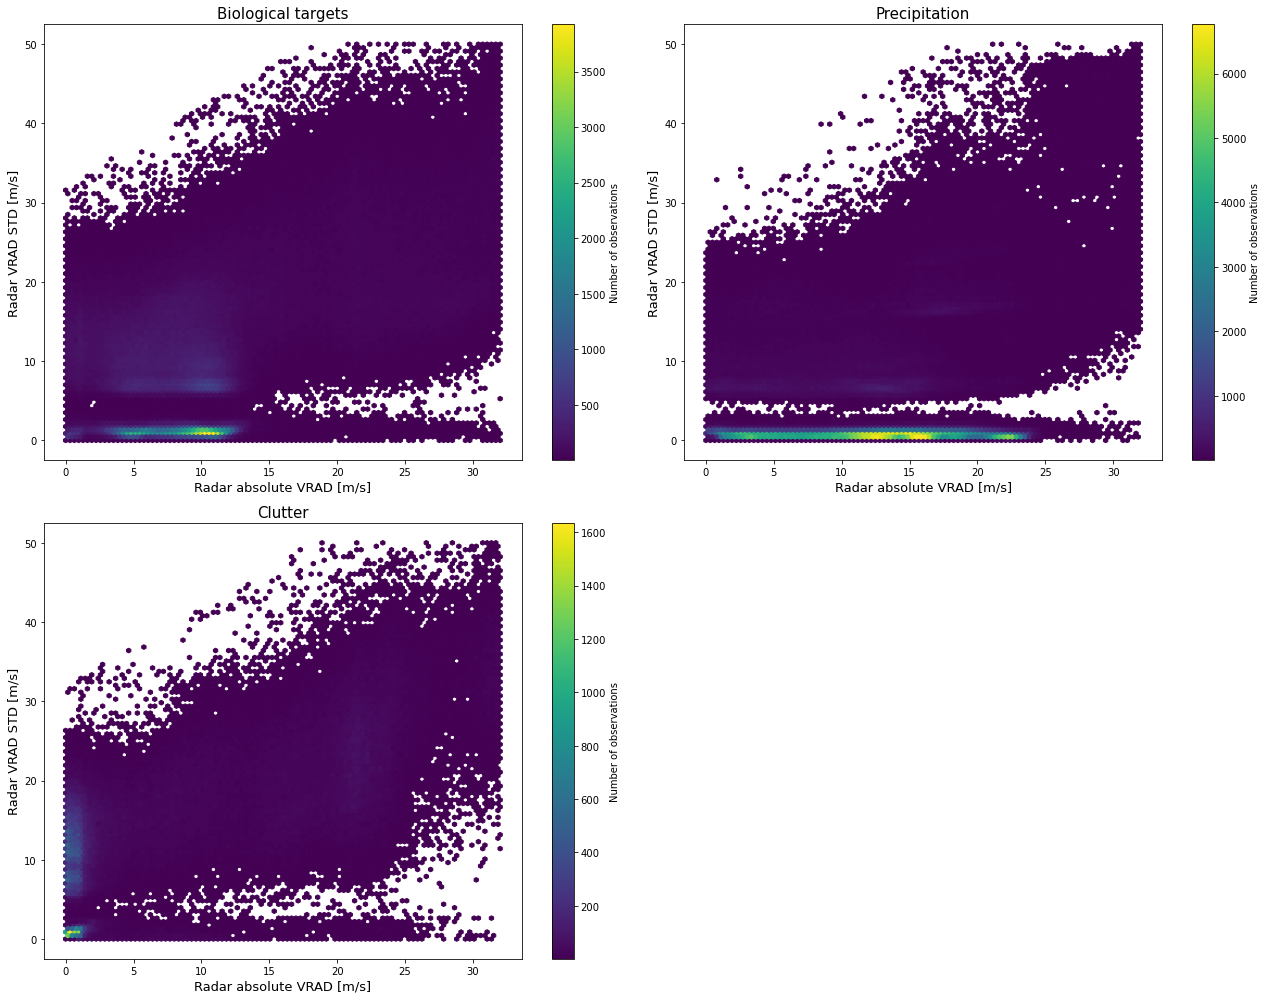

In [24]:
plt.figure(figsize=(18,14))

plt.subplot(221)
plt.hexbin(np.absolute(VRAD_b[:]),VRAD_tex_b[:], mincnt=0.1,gridsize=100,extent=(0,32,0,50)) #,vmax=50)
           #mincnt=1,gridsize=80,extent=(-30,50,-30,50),
           #cmap=plt.cm.magma,
           #bins='log')
#cc=np.corrcoef(results['rad1_dbzh'],results['rad2_dbzh'])[0, 1]
plt.colorbar(label='Number of observations')
plt.xlabel('Radar absolute VRAD [m/s]', fontsize = 13)
plt.ylabel('Radar VRAD STD [m/s]', fontsize = 13)
plt.title('Biological targets', fontsize = 15)

plt.subplot(222)
plt.hexbin(np.absolute(VRAD_p[:]),VRAD_tex_p[:], mincnt=0.1,gridsize=100,extent=(0,32,0,50)) #,vmax=50)
           #mincnt=1,gridsize=80,extent=(-30,50,-30,50),
           #cmap=plt.cm.magma,
           #bins='log')
#cc=np.corrcoef(results['rad1_dbzh'],results['rad2_dbzh'])[0, 1]
plt.colorbar(label='Number of observations')
plt.xlabel('Radar absolute VRAD [m/s]', fontsize = 13)
plt.ylabel('Radar VRAD STD [m/s]', fontsize = 13)
plt.title('Precipitation', fontsize = 15)

plt.subplot(223)
plt.hexbin(np.absolute(VRAD_c[:]),VRAD_tex_c[:], mincnt=0.1,gridsize=100,extent=(0,32,0,50)) #,vmax=50)
           #mincnt=1,gridsize=80,extent=(-30,50,-30,50),
           #cmap=plt.cm.magma,
           #bins='log')
#cc=np.corrcoef(results['rad1_dbzh'],results['rad2_dbzh'])[0, 1]
plt.colorbar(label='Number of observations')
plt.xlabel('Radar absolute VRAD [m/s]', fontsize = 13)
plt.ylabel('Radar VRAD STD [m/s]', fontsize = 13)
plt.title('Clutter', fontsize = 15)


OUT_PATH = "C:/Users/leona/Desktop/Plots/"
plt.tight_layout()
### Uncomment to save
#plt.savefig(OUT_PATH + 'VRAD_vs_VRAD_STD.png', facecolor='white')

Note: it looks like bulk of data (for biological targets and precipitation) has low VRAD STD (lower than 4.5-5m/s). I will filter out high VRAD STD in order to have more accurate data to train my model. 

### Filter data based on general knowledge on each class

In [25]:
### overall filter for biological targets
filter_b = np.all([clu_map_b<10,                    #to remove static clutter
                   np.any([VRAD_b>1,
                           VRAD_b<-1],axis=0),      #only absolte VRAD>1m/s, still for static clutter
                   VRAD_tex_b<=4.5,                 #VRAD STD, see above  
                   #DR_b>-12,                       #DR
                   #RHOHV_b<=0.95,                  #RHOHV
                   ],axis=0)

In [26]:
### overall filter for precipitation
filter_p = np.all([clu_map_p<10,                    #to remove static clutter
                   np.any([VRAD_p>1,
                           VRAD_p<-1],axis=0),      #only absolte VRAD>1m/s, still for static clutter
                   VRAD_tex_p<=4.5,                 #VRAD STD
                   #DR_p>-12,                       #DR
                   #RHOHV_p>0.95,                   #RHOHV                   
                   ],axis=0)

In [27]:
### overall filter for clutter
filter_c = np.all([VRAD_c<=3,
                   VRAD_c>=-3,                      #VRAD
                   #DR_c>-12,                       #DR
                   RHOHV_c<=1,                      #RHOHV
                   ],axis=0)

### Plot histograms for variables + Kernel Density Estimation (KDE)

C:\Users\leona\anaconda3\envs\myenv\lib\site-packages\numpy\lib\histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
C:\Users\leona\anaconda3\envs\myenv\lib\site-packages\numpy\lib\histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


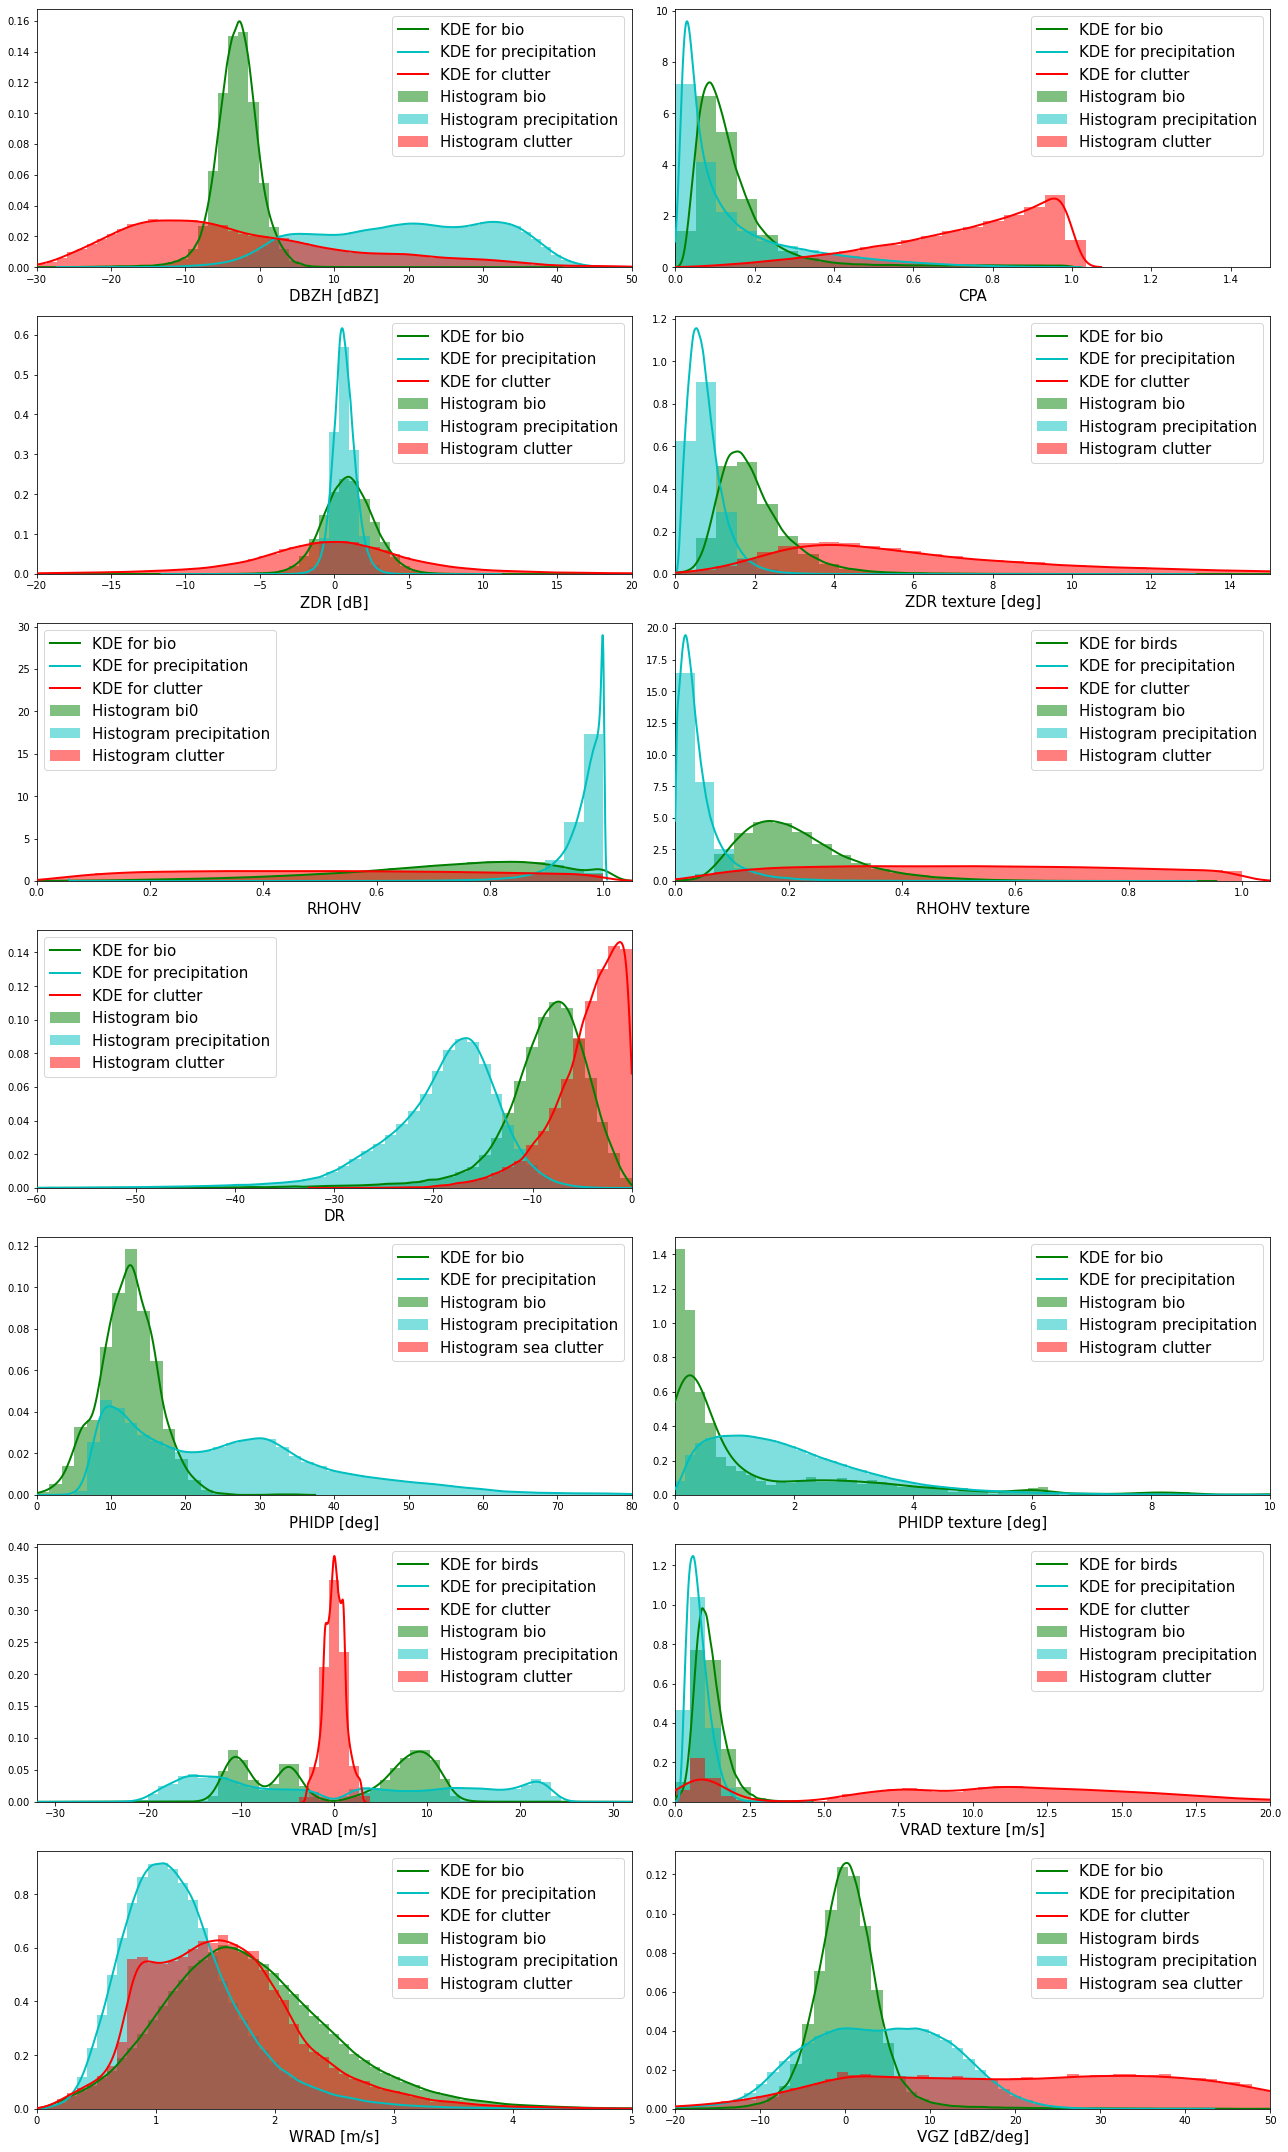

In [28]:
fig, axs = plt.subplots(7, 2, figsize=(18,30))

### DBZH
data_b = DBZH_b[filter_b]
data_b = data_b[np.isfinite(data_b)]
data_p = DBZH_p[filter_p]
data_p = data_p[np.isfinite(data_p)]
data_c = DBZH_c[filter_c]
data_c = data_c[np.isfinite(data_c)]

bins = np.linspace(-30, 50, 60)
ax0 = axs[0,0]
ax0.hist(data_b, bins, label = 'Histogram bio', density=True, alpha = 0.5, color='g')
ax0.hist(data_p, bins, label = 'Histogram precipitation', density=True, alpha = 0.5, color='c')
ax0.hist(data_c, bins, label = 'Histogram clutter', density=True, alpha = 0.5, color='r')
ax0.set_xlabel('DBZH [dBZ]', fontsize=15)

# Plot the KDE as fitted using the default arguments
kde_b = sm.nonparametric.KDEUnivariate(data_b)
kde_b.fit() # Estimate the densities
ax0.plot(kde_b.support, kde_b.density, lw=2, label='KDE for bio', zorder=10, color='g')

kde_p = sm.nonparametric.KDEUnivariate(data_p)
kde_p.fit() # Estimate the densities
ax0.plot(kde_p.support, kde_p.density, lw=2, label='KDE for precipitation', zorder=10, color='c')

kde_c = sm.nonparametric.KDEUnivariate(data_c)
kde_c.fit() # Estimate the densities
ax0.plot(kde_c.support, kde_c.density, lw=2, label='KDE for clutter', zorder=10, color='r')

ax0.set_xlim(-30,50)
ax0.legend(fontsize=15)


### CPA
data_b = CPA_b[filter_b]
data_b = data_b[np.isfinite(data_b)]
data_p = CPA_p[filter_p]
data_p = data_p[np.isfinite(data_p)]
data_c = CPA_c[filter_c]
data_c = data_c[np.isfinite(data_c)]

bins = np.linspace(0, 1.5, 30)
ax0 = axs[0,1]
ax0.hist(data_b, bins, label = 'Histogram bio', density=True, alpha = 0.5, color='g')
ax0.hist(data_p, bins, label = 'Histogram precipitation', density=True, alpha = 0.5, color='c')
ax0.hist(data_c, bins, label = 'Histogram clutter', density=True, alpha = 0.5, color='r')
ax0.set_xlabel('CPA', fontsize=15)

# Plot the KDE as fitted using the default arguments
kde_b = sm.nonparametric.KDEUnivariate(data_b)
kde_b.fit() # Estimate the densities
ax0.plot(kde_b.support, kde_b.density, lw=2, label='KDE for bio', zorder=10, color='g')

kde_p = sm.nonparametric.KDEUnivariate(data_p)
kde_p.fit() # Estimate the densities
ax0.plot(kde_p.support, kde_p.density, lw=2, label='KDE for precipitation', zorder=10, color='c')

kde_c = sm.nonparametric.KDEUnivariate(data_c)
kde_c.fit() # Estimate the densities
ax0.plot(kde_c.support, kde_c.density, lw=2, label='KDE for clutter', zorder=10, color='r')

ax0.set_xlim(0,1.5)
ax0.legend(fontsize=15)


### ZDR
data_b = ZDR_b[filter_b]
data_b = data_b[np.isfinite(data_b)]
data_p = ZDR_p[filter_p]
data_p = data_p[np.isfinite(data_p)]
data_c = ZDR_c[filter_c]
data_c = data_c[np.isfinite(data_c)]

bins = np.linspace(-20, 20, 60)
ax0 = axs[1,0]
ax0.hist(data_b, bins, label = 'Histogram bio', density=True, alpha = 0.5, color='g')
ax0.hist(data_p, bins, label = 'Histogram precipitation', density=True, alpha = 0.5, color='c')
ax0.hist(data_c, bins, label = 'Histogram clutter', density=True, alpha = 0.5, color='r')
ax0.set_xlabel('ZDR [dB]', fontsize=15)

# Plot the KDE as fitted using the default arguments
kde_b = sm.nonparametric.KDEUnivariate(data_b)
kde_b.fit() # Estimate the densities
ax0.plot(kde_b.support, kde_b.density, lw=2, label='KDE for bio', zorder=10, color='g')

kde_p = sm.nonparametric.KDEUnivariate(data_p)
kde_p.fit() # Estimate the densities
ax0.plot(kde_p.support, kde_p.density, lw=2, label='KDE for precipitation', zorder=10, color='c')

kde_c = sm.nonparametric.KDEUnivariate(data_c)
kde_c.fit() # Estimate the densities
ax0.plot(kde_c.support, kde_c.density, lw=2, label='KDE for clutter', zorder=10, color='r')

ax0.set_xlim(-20,20)
ax0.legend(fontsize=15)


### ZDR texture
data_b = ZDR_tex_b[filter_b]
data_b = data_b[np.isfinite(data_b)]
data_p = ZDR_tex_p[filter_p]
data_p = data_p[np.isfinite(data_p)]
data_c = ZDR_tex_c[filter_c]
data_c = data_c[np.isfinite(data_c)]

bins = np.linspace(0, 15, 30)
ax0 = axs[1,1]
ax0.hist(data_b, bins, label = 'Histogram bio', density=True, alpha = 0.5, color='g')
ax0.hist(data_p, bins, label = 'Histogram precipitation', density=True, alpha = 0.5, color='c')
ax0.hist(data_c, bins, label = 'Histogram clutter', density=True, alpha = 0.5, color = 'r')
ax0.set_xlabel('ZDR texture [deg]', fontsize=15)

# Plot the KDE as fitted using the default arguments
kde_b = sm.nonparametric.KDEUnivariate(data_b)
kde_b.fit() # Estimate the densities
ax0.plot(kde_b.support, kde_b.density, lw=2, label='KDE for bio', zorder=10, color='g')

kde_p = sm.nonparametric.KDEUnivariate(data_p)
kde_p.fit() # Estimate the densities
ax0.plot(kde_p.support, kde_p.density, lw=2, label='KDE for precipitation', zorder=10, color='c')

kde_c = sm.nonparametric.KDEUnivariate(data_c)
kde_c.fit() # Estimate the densities
ax0.plot(kde_c.support, kde_c.density, lw=2, label='KDE for clutter', zorder=10, color='r')

ax0.set_xlim(0,15)
ax0.legend(fontsize=15)


### RHOHV
data_b = RHOHV_b[filter_b]
data_b = data_b[np.isfinite(data_b)]
data_p = RHOHV_p[filter_p]
data_p = data_p[np.isfinite(data_p)]
data_c = RHOHV_c[filter_c]
data_c = data_c[np.isfinite(data_c)]

bins = np.linspace(0, 1, 30)
ax0 = axs[2,0]
ax0.hist(data_b, bins, label = 'Histogram bi0', density=True, alpha = 0.5, color='g')
ax0.hist(data_p, bins, label = 'Histogram precipitation', density=True, alpha = 0.5, color='c')
ax0.hist(data_c, bins, label = 'Histogram clutter', density=True, alpha = 0.5, color = 'r')
ax0.set_xlabel('RHOHV', fontsize=15)

# Plot the KDE as fitted using the default arguments
kde_b = sm.nonparametric.KDEUnivariate(data_b)
kde_b.fit() # Estimate the densities
ax0.plot(kde_b.support, kde_b.density, lw=2, label='KDE for bio', zorder=10, color='g')

kde_p = sm.nonparametric.KDEUnivariate(data_p)
kde_p.fit() # Estimate the densities
ax0.plot(kde_p.support, kde_p.density, lw=2, label='KDE for precipitation', zorder=10, color='c')

kde_c = sm.nonparametric.KDEUnivariate(data_c)
kde_c.fit() # Estimate the densities
ax0.plot(kde_c.support, kde_c.density, lw=2, label='KDE for clutter', zorder=10, color='r')

ax0.set_xlim(0,1.05)
ax0.legend(fontsize=15)


### RHOHV texture
data_b = RHOHV_tex_b[filter_b]
data_b = data_b[np.isfinite(data_b)]
data_p = RHOHV_tex_p[filter_p]
data_p = data_p[np.isfinite(data_p)]
data_c = RHOHV_c[filter_c]
data_c = data_c[np.isfinite(data_c)]

bins = np.linspace(0, 1, 30)
ax0 = axs[2,1]
ax0.hist(data_b, bins, label = 'Histogram bio', density=True, alpha = 0.5, color='g')
ax0.hist(data_p, bins, label = 'Histogram precipitation', density=True, alpha = 0.5, color='c')
ax0.hist(data_c, bins, label = 'Histogram clutter', density=True, alpha = 0.5, color = 'r')
ax0.set_xlabel('RHOHV texture', fontsize=15)

# Plot the KDE as fitted using the default arguments
kde_b = sm.nonparametric.KDEUnivariate(data_b)
kde_b.fit() # Estimate the densities
ax0.plot(kde_b.support, kde_b.density, lw=2, label='KDE for birds', zorder=10, color='g')

kde_p = sm.nonparametric.KDEUnivariate(data_p)
kde_p.fit() # Estimate the densities
ax0.plot(kde_p.support, kde_p.density, lw=2, label='KDE for precipitation', zorder=10, color='c')

kde_c = sm.nonparametric.KDEUnivariate(data_c)
kde_c.fit() # Estimate the densities
ax0.plot(kde_c.support, kde_c.density, lw=2, label='KDE for clutter', zorder=10, color='r')
ax0.legend()

ax0.set_xlim(0,1.05)
ax0.legend(fontsize=15)


### DR
data_b = DR_b[filter_b]
data_b = data_b[np.isfinite(data_b)]
data_p = DR_p[filter_p]
data_p = data_p[np.isfinite(data_p)]
data_c = DR_c[filter_c]
data_c = data_c[np.isfinite(data_c)]

bins = np.linspace(-70, 0, 60)
ax0 = axs[3,0]
ax0.hist(data_b, bins, label = 'Histogram bio', density=True, alpha = 0.5, color='g')
ax0.hist(data_p, bins, label = 'Histogram precipitation', density=True, alpha = 0.5, color='c')
ax0.hist(data_c, bins, label = 'Histogram clutter', density=True, alpha = 0.5, color = 'r')
ax0.set_xlabel('DR', fontsize=15)

# Plot the KDE as fitted using the default arguments
kde_b = sm.nonparametric.KDEUnivariate(data_b)
kde_b.fit() # Estimate the densities
ax0.plot(kde_b.support, kde_b.density, lw=2, label='KDE for bio', zorder=10, color='g')

kde_p = sm.nonparametric.KDEUnivariate(data_p)
kde_p.fit() # Estimate the densities
ax0.plot(kde_p.support, kde_p.density, lw=2, label='KDE for precipitation', zorder=10, color='c')

kde_c = sm.nonparametric.KDEUnivariate(data_c)
kde_c.fit() # Estimate the densities
ax0.plot(kde_c.support, kde_c.density, lw=2, label='KDE for clutter', zorder=10, color='r')

ax0.set_xlim(-60,0)
ax0.legend(fontsize=15)

ax = axs[3,1]
ax.axis('off')

### PHIDP
data_b = PHIDP_b[filter_b]
data_b = data_b[np.isfinite(data_b)]
data_p = PHIDP_p[filter_p]
data_p = data_p[np.isfinite(data_p)]
data_c = PHIDP_c[filter_c]
data_c = data_c[np.isfinite(data_c)]

bins = np.linspace(0, 100, 60)
ax0 = axs[4,0]
ax0.hist(data_b, bins, label = 'Histogram bio', density=True, alpha = 0.5, color='g')
ax0.hist(data_p, bins, label = 'Histogram precipitation', density=True, alpha = 0.5, color='c')
ax0.hist(data_c, bins, label = 'Histogram sea clutter', density=True, alpha = 0.5, color = 'r')
ax0.set_xlabel('PHIDP [deg]', fontsize=15)

# Plot the KDE as fitted using the default arguments
kde_b = sm.nonparametric.KDEUnivariate(data_b)
kde_b.fit() # Estimate the densities
ax0.plot(kde_b.support, kde_b.density, lw=2, label='KDE for bio', zorder=10, color='g')

kde_p = sm.nonparametric.KDEUnivariate(data_p)
kde_p.fit() # Estimate the densities
ax0.plot(kde_p.support, kde_p.density, lw=2, label='KDE for precipitation', zorder=10, color='c')

#kde_c = sm.nonparametric.KDEUnivariate(data_c)
#kde_c.fit() # Estimate the densities
#ax0.plot(kde_c.support, kde_c.density, lw=2, label='KDE for clutter', zorder=10, color='r')
ax0.set_xlim(0,80)
ax0.legend(fontsize=15)


### PHIDP texture
data_b = PHIDP_tex_b[filter_b]
data_b = data_b[np.isfinite(data_b)]
data_p = PHIDP_tex_p[filter_p]
data_p = data_p[np.isfinite(data_p)]
data_c = PHIDP_tex_c[filter_c]
data_c = data_c[np.isfinite(data_c)]

bins = np.linspace(0, 10, 60)
ax0 = axs[4,1]
ax0.hist(data_b, bins, label = 'Histogram bio', density=True, alpha = 0.5, color='g')
ax0.hist(data_p, bins, label = 'Histogram precipitation', density=True, alpha = 0.5, color='c')
ax0.hist(data_c, bins, label = 'Histogram clutter', density=True, alpha = 0.5, color = 'r')
ax0.set_xlabel('PHIDP texture [deg]', fontsize=15)

# Plot the KDE as fitted using the default arguments
kde_b = sm.nonparametric.KDEUnivariate(data_b)
kde_b.fit() # Estimate the densities
ax0.plot(kde_b.support, kde_b.density, lw=2, label='KDE for bio', zorder=10, color='g')

kde_p = sm.nonparametric.KDEUnivariate(data_p)
kde_p.fit() # Estimate the densities
ax0.plot(kde_p.support, kde_p.density, lw=2, label='KDE for precipitation', zorder=10, color='c')

#kde_c = sm.nonparametric.KDEUnivariate(data_c)
#kde_c.fit() # Estimate the densities
#ax0.plot(kde_c.support, kde_c.density, lw=2, label='KDE for clutter', zorder=10, color='r')
ax0.set_xlim(0,10)
ax0.legend(fontsize=15)


### VRAD
data_b = VRAD_b[filter_b]
data_b = data_b[np.isfinite(data_b)]
data_p = VRAD_p[filter_p]
data_p = data_p[np.isfinite(data_p)]
data_c = VRAD_c[filter_c]
data_c = data_c[np.isfinite(data_c)]

bins = np.linspace(-32, 32, 60)
ax0 = axs[5,0]
ax0.hist(data_b, bins, label = 'Histogram bio', density=True, alpha = 0.5, color='g')
ax0.hist(data_p, bins, label = 'Histogram precipitation', density=True, alpha = 0.5, color='c')
ax0.hist(data_c, bins, label = 'Histogram clutter', density=True, alpha = 0.5, color = 'r')
ax0.set_xlabel('VRAD [m/s]', fontsize=15)

# Plot the KDE as fitted using the default arguments
kde_b = sm.nonparametric.KDEUnivariate(data_b)
kde_b.fit() # Estimate the densities
ax0.plot(kde_b.support, kde_b.density, lw=2, label='KDE for birds', zorder=10, color='g')

kde_p = sm.nonparametric.KDEUnivariate(data_p)
kde_p.fit() # Estimate the densities
ax0.plot(kde_p.support, kde_p.density, lw=2, label='KDE for precipitation', zorder=10, color='c')

kde_c = sm.nonparametric.KDEUnivariate(data_c)
kde_c.fit() # Estimate the densities
ax0.plot(kde_c.support, kde_c.density, lw=2, label='KDE for clutter', zorder=10, color='r')

ax0.set_xlim(-32,32)
ax0.legend(fontsize=15)


### VRAD texture
data_b = VRAD_tex_b[filter_b]
data_b = data_b[np.isfinite(data_b)]
data_p = VRAD_tex_p[filter_p]
data_p = data_p[np.isfinite(data_p)]
data_c = VRAD_tex_c[filter_c]
data_c = data_c[np.isfinite(data_c)]

bins = np.linspace(0, 30, 60)
ax0 = axs[5,1]
ax0.hist(data_b, bins, label = 'Histogram bio', density=True, alpha = 0.5, color='g')
ax0.hist(data_p, bins, label = 'Histogram precipitation', density=True, alpha = 0.5, color='c')
ax0.hist(data_c, bins, label = 'Histogram clutter', density=True, alpha = 0.5, color = 'r')
ax0.set_xlabel('VRAD texture [m/s]', fontsize=15)

# Plot the KDE as fitted using the default arguments
kde_b = sm.nonparametric.KDEUnivariate(data_b)
kde_b.fit() # Estimate the densities
ax0.plot(kde_b.support, kde_b.density, lw=2, label='KDE for birds', zorder=10, color='g')


kde_p = sm.nonparametric.KDEUnivariate(data_p)
kde_p.fit() # Estimate the densities
ax0.plot(kde_p.support, kde_p.density, lw=2, label='KDE for precipitation', zorder=10, color='c')

kde_c = sm.nonparametric.KDEUnivariate(data_c)
kde_c.fit() # Estimate the densities
ax0.plot(kde_c.support, kde_c.density, lw=2, label='KDE for clutter', zorder=10, color='r')

ax0.set_xlim(0,20)
ax0.legend(fontsize=15)


### WRAD
data_b = WRAD_b[filter_b]
data_b = data_b[np.isfinite(data_b)]
data_p = WRAD_p[filter_p]
data_p = data_p[np.isfinite(data_p)]
data_c = WRAD_c[filter_c]
data_c = data_c[np.isfinite(data_c)]

bins = np.linspace(0, 5, 60)
ax0 = axs[6,0]
ax0.hist(data_b, bins, label = 'Histogram bio', density=True, alpha = 0.5, color='g')
ax0.hist(data_p, bins, label = 'Histogram precipitation', density=True, alpha = 0.5, color='c')
ax0.hist(data_c, bins, label = 'Histogram clutter', density=True, alpha = 0.5, color = 'r')
ax0.set_xlabel('WRAD [m/s]', fontsize=15)

# Plot the KDE as fitted using the default arguments
kde_b = sm.nonparametric.KDEUnivariate(data_b)
kde_b.fit() # Estimate the densities
ax0.plot(kde_b.support, kde_b.density, lw=2, label='KDE for bio', zorder=10, color='g')

kde_p = sm.nonparametric.KDEUnivariate(data_p)
kde_p.fit() # Estimate the densities
ax0.plot(kde_p.support, kde_p.density, lw=2, label='KDE for precipitation', zorder=10, color='c')

kde_c = sm.nonparametric.KDEUnivariate(data_c)
kde_c.fit() # Estimate the densities
ax0.plot(kde_c.support, kde_c.density, lw=2, label='KDE for clutter', zorder=10, color='r')
ax0.legend()

ax0.set_xlim(0,5)
ax0.legend(fontsize=15)


### VGZ
data_b = VGZ_b[filter_b]
data_b = data_b[np.isfinite(data_b)]
data_p = VGZ_p[filter_p]
data_p = data_p[np.isfinite(data_p)]
data_c = VGZ_c[filter_c]
data_c = data_c[np.isfinite(data_c)]

bins = np.linspace(-20, 60, 60)
ax0 = axs[6,1]
ax0.hist(data_b, bins, label = 'Histogram birds', density=True, alpha = 0.5, color='g')
ax0.hist(data_p, bins, label = 'Histogram precipitation', density=True, alpha = 0.5, color='c')
ax0.hist(data_c, bins, label = 'Histogram sea clutter', density=True, alpha = 0.5, color='r')
ax0.set_xlabel('VGZ [dBZ/deg]', fontsize=15)

# Plot the KDE as fitted using the default arguments
kde_b = sm.nonparametric.KDEUnivariate(data_b)
kde_b.fit() # Estimate the densities
ax0.plot(kde_b.support, kde_b.density, lw=2, label='KDE for bio', zorder=10, color='g')

kde_p = sm.nonparametric.KDEUnivariate(data_p)
kde_p.fit() # Estimate the densities
ax0.plot(kde_p.support, kde_p.density, lw=2, label='KDE for precipitation', zorder=10, color='c')

kde_c = sm.nonparametric.KDEUnivariate(data_c)
kde_c.fit() # Estimate the densities
ax0.plot(kde_c.support, kde_c.density, lw=2, label='KDE for clutter', zorder=10, color='r')

ax0.set_xlim(-20,50)
ax0.legend(fontsize=15)

OUT_PATH = "C:/Users/leona/Desktop/Plots/"
plt.tight_layout()
#plt.savefig(OUT_PATH + 'KDE_pdfs', facecolor='white')

Notes:
- Should I be more selective in bio selection? I am using VRAD texture to filter (also for precipitation). VRAD texture (or STD) has a bimodal distribution. 
- Variables to use: DBZH (??), CPA, ZDR texture, RHOHV texture, DR, WRAD (?), VGZ (?), PHIDP texture (?)

### Membership functions

#### Function to calculate intersection between histograms, useful to calculate weight of each variable

In [29]:
def histogram_intersection(h1, h2, h3):
    sm = 0
    for i in range(len(h1)):
        sm += min(h1[i], h2[i], h3[i])
    return sm

#### DBZH

overlapping area =  0.11110881451364878


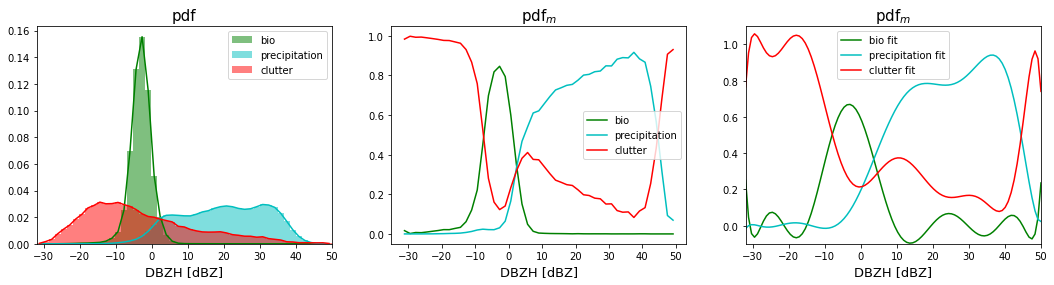

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(18,4))

### DBZH
data_b = DBZH_b[filter_b]
data_b = data_b[np.isfinite(data_b)]
data_p = DBZH_p[filter_p]
data_p = data_p[np.isfinite(data_p)]
data_c = DBZH_c[filter_c]
data_c = data_c[np.isfinite(data_c)]

bins = np.linspace(-32, 50, 50)
bins2 = np.zeros((len(bins)-1,1))
for i in np.arange(0,len(bins)-1):
    bins2[i] = (bins[i+1] + bins[i])/2
    
ax0 = axs[0]
hb = ax0.hist(data_b, bins, label = 'bio', density=True, alpha = 0.5, color='g')
ax0.plot(bins2,hb[0],color='g')
hp = ax0.hist(data_p, bins, label = 'precipitation', density=True, alpha = 0.5, color='c')
ax0.plot(bins2,hp[0],color='c')
hc = ax0.hist(data_c, bins, label = 'clutter', density=True, alpha = 0.5, color='r')
ax0.plot(bins2,hc[0],color='r')

ax0.legend(fontsize = 10)
ax0.set_title('pdf',fontsize = 15)
ax0.set_xlabel('DBZH [dBZ]',fontsize = 13)
ax0.set_xlim(-32,50)


### part 2
h_sum = hb[0] + hp[0] + hc[0]
hb_m = hb[0]/h_sum
hp_m = hp[0]/h_sum
hc_m = hc[0]/h_sum

ax0 = axs[1]
ax0.plot(bins2,hb_m, color='g', label = 'bio')
ax0.plot(bins2,hp_m, color='c', label = 'precipitation')
ax0.plot(bins2,hc_m, color='r', label = 'clutter')
ax0.legend(fontsize = 10)
ax0.set_title('pdf$_m$',fontsize = 15)
ax0.set_xlabel('DBZH [dBZ]',fontsize = 13)
#ax0.set_ylim(-0.1,1.1)
#ax0.set_xlim(-32,50)


### part 3
x = bins2.flatten()

x_b = x[~np.isnan(hb_m)]
y_b = hb_m[~np.isnan(hb_m)]
z_b = np.polyfit(x_b, y_b, 10)

x_p = x[~np.isnan(hp_m)]
y_p = hp_m[~np.isnan(hp_m)]
z_p = np.polyfit(x_p, y_p, 10)

x_c = x[~np.isnan(hc_m)]
y_c = hc_m[~np.isnan(hc_m)]
z_c = np.polyfit(x_c, y_c, 10)


p_dbzh_b = np.poly1d(z_b)
p_dbzh_p = np.poly1d(z_p)
p_dbzh_c = np.poly1d(z_c)


ax0 = axs[2]
xn = np.linspace(-32, 50, 100)
ax0.plot(xn, p_dbzh_b(xn), 'g-', label='bio fit')
ax0.plot(xn, p_dbzh_p(xn), 'c-', label='precipitation fit')
ax0.plot(xn, p_dbzh_c(xn), 'r-', label='clutter fit')
ax0.legend(fontsize = 10)
ax0.set_title('pdf$_m$',fontsize = 15)
ax0.set_xlabel('DBZH [dBZ]',fontsize = 13)
ax0.set_ylim(-0.1,1.1)
ax0.set_xlim(-32,50)

#kde_b = sm.nonparametric.KDEUnivariate(data_b)
#kde_p = sm.nonparametric.KDEUnivariate(data_p)
#kde_c = sm.nonparametric.KDEUnivariate(data_c)

#kde_b.fit() # Estimate the densities
#kde_p.fit()
#kde_c.fit()
#kde_tot = kde_b.density + kde_p.density + kde_c.density

#ax0.plot(kde_b.support, kde_b.density, lw=2, label='KDE for bio', zorder=10, color='g')
#ax0.plot(kde_p.support, kde_p.density, lw=2, label='KDE for bio', zorder=10, color='c')
#ax0.plot(kde_c.support, kde_c.density, lw=2, label='KDE for bio', zorder=10, color='r')
#ax0.set_ylim(0,1)
#ax0.set_xlim(-32,50)

### overlap
A_dbzh = histogram_intersection(hb[0],hp[0],hc[0])*(hb[1][1]-hb[1][0])
print('overlapping area = ',A_dbzh)

#plt.tight_layout()
#plt.savefig(OUT_PATH + 'membership_DBZH', facecolor='white')

#### CPA

C:\Users\leona\AppData\Local\Temp/ipykernel_5912/668613869.py:32: RuntimeWarning: invalid value encountered in true_divide
  hb_m = hb[0]/h_sum
C:\Users\leona\AppData\Local\Temp/ipykernel_5912/668613869.py:33: RuntimeWarning: invalid value encountered in true_divide
  hp_m = hp[0]/h_sum
C:\Users\leona\AppData\Local\Temp/ipykernel_5912/668613869.py:34: RuntimeWarning: invalid value encountered in true_divide
  hc_m = hc[0]/h_sum


overlapping area =  0.10690735260332349


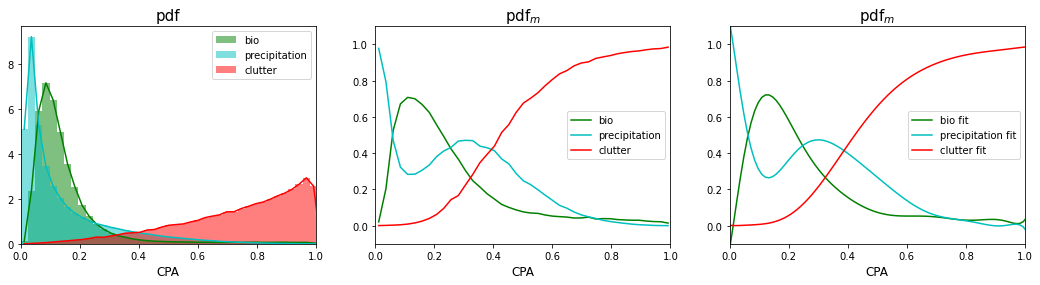

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(18,4))

### CPA
data_b = CPA_b[filter_b]
data_b = data_b[np.isfinite(data_b)]
data_p = CPA_p[filter_p]
data_p = data_p[np.isfinite(data_p)]
data_c = CPA_c[filter_c]
data_c = data_c[np.isfinite(data_c)]

bins = np.linspace(0, 1.2, 50)
bins2 = np.zeros((len(bins)-1,1))
for i in np.arange(0,len(bins)-1):
    bins2[i] = (bins[i+1] + bins[i])/2
    
ax0 = axs[0]
hb = ax0.hist(data_b, bins, label = 'bio', density=True, alpha = 0.5, color='g')
ax0.plot(bins2,hb[0],color='g')
hp = ax0.hist(data_p, bins, label = 'precipitation', density=True, alpha = 0.5, color='c')
ax0.plot(bins2,hp[0],color='c')
hc = ax0.hist(data_c, bins, label = 'clutter', density=True, alpha = 0.5, color='r')
ax0.plot(bins2,hc[0],color='r')

ax0.legend(fontsize = 10)
ax0.set_title('pdf',fontsize = 15)
ax0.set_xlabel('CPA',fontsize = 12)
ax0.set_xlim(0,1)


### part 2
h_sum = hb[0] + hp[0] + hc[0]
hb_m = hb[0]/h_sum
hp_m = hp[0]/h_sum
hc_m = hc[0]/h_sum

x = bins2.flatten()

x_b = x[~np.isnan(hb_m)]
y_b = hb_m[~np.isnan(hb_m)]
z_b = np.polyfit(x_b, y_b, 10)

x_p = x[~np.isnan(hp_m)]
y_p = hp_m[~np.isnan(hp_m)]
z_p = np.polyfit(x_p, y_p, 10)

x_c = x[~np.isnan(hc_m)]
y_c = hc_m[~np.isnan(hc_m)]
z_c = np.polyfit(x_c, y_c, 10)

p_cpa_b = np.poly1d(z_b)
p_cpa_p = np.poly1d(z_p)
p_cpa_c = np.poly1d(z_c)

xn = np.linspace(0, 1.2, 100)
ax0 = axs[1]
ax0.plot(bins2,hb_m, color='g', label = 'bio')
ax0.plot(bins2,hp_m, color='c', label = 'precipitation')
ax0.plot(bins2,hc_m, color='r', label = 'clutter')
#ax0.plot(xn, p_b(xn), 'g--', label='birds fit')
#ax0.plot(xn, p_i(xn), 'y--', label='insects fit')
#ax0.plot(xn, p_p(xn), 'c--', label='precipitation fit')
ax0.legend(fontsize = 10)
ax0.set_title('pdf$_m$',fontsize = 15)
ax0.set_xlabel('CPA',fontsize = 12)
ax0.set_ylim(-0.1,1.1)
ax0.set_xlim(0,1)


### part 3
ax0 = axs[2]
ax0.plot(xn, p_cpa_b(xn), 'g-', label='bio fit')
ax0.plot(xn, p_cpa_p(xn), 'c-', label='precipitation fit')
ax0.plot(xn, p_cpa_c(xn), 'r-', label='clutter fit')
ax0.legend(fontsize = 10)
ax0.set_title('pdf$_m$',fontsize = 15)
ax0.set_xlabel('CPA',fontsize = 12)
ax0.set_ylim(-0.1,1.1)
ax0.set_xlim(0,1)

### overlap
A_cpa = histogram_intersection(hb[0],hp[0],hc[0])*(hb[1][1]-hb[1][0])
print('overlapping area = ',A_cpa)

#plt.tight_layout()
#plt.savefig(OUT_PATH + 'membership_CPA', facecolor='white')

#### ZDR texture

overlapping area =  0.08460990121410028


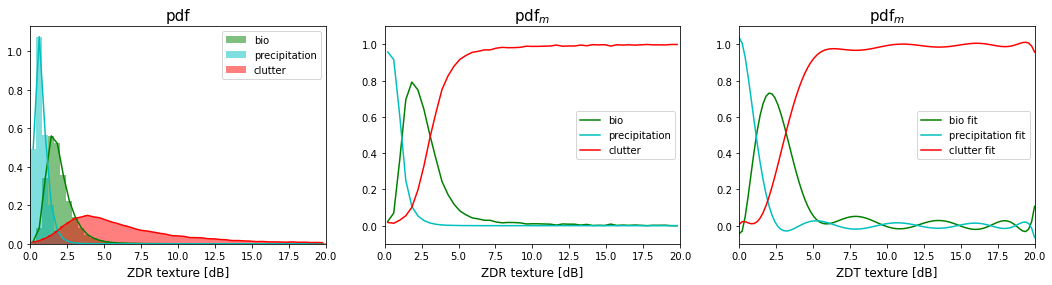

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(18,4))

### ZDR tex
data_b = ZDR_tex_b[filter_b]
data_b = data_b[np.isfinite(data_b)]
data_p = ZDR_tex_p[filter_p]
data_p = data_p[np.isfinite(data_p)]
data_c = ZDR_tex_c[filter_c]
data_c = data_c[np.isfinite(data_c)]

bins = np.linspace(0, 20, 50)
bins2 = np.zeros((len(bins)-1,1))
for i in np.arange(0,len(bins)-1):
    bins2[i] = (bins[i+1] + bins[i])/2
    
ax0 = axs[0]
hb = ax0.hist(data_b, bins, label = 'bio', density=True, alpha = 0.5, color='g')
ax0.plot(bins2,hb[0],color='g')
hp = ax0.hist(data_p, bins, label = 'precipitation', density=True, alpha = 0.5, color='c')
ax0.plot(bins2,hp[0],color='c')
hc = ax0.hist(data_c, bins, label = 'clutter', density=True, alpha = 0.5, color='r')
ax0.plot(bins2,hc[0],color='r')

ax0.legend(fontsize = 10)
ax0.set_title('pdf',fontsize = 15)
ax0.set_xlabel('ZDR texture [dB]',fontsize = 12)
ax0.set_xlim(0,20)


### part 2
h_sum = hb[0] + hp[0] + hc[0]
hb_m = hb[0]/h_sum
hp_m = hp[0]/h_sum
hc_m = hc[0]/h_sum

x = bins2.flatten()

x_b = x[~np.isnan(hb_m)]
y_b = hb_m[~np.isnan(hb_m)]
z_b = np.polyfit(x_b, y_b, 10)

x_p = x[~np.isnan(hp_m)]
y_p = hp_m[~np.isnan(hp_m)]
z_p = np.polyfit(x_p, y_p, 10)

x_c = x[~np.isnan(hc_m)]
y_c = hc_m[~np.isnan(hc_m)]
z_c = np.polyfit(x_c, y_c, 10)

p_zdrt_b = np.poly1d(z_b)
p_zdrt_p = np.poly1d(z_p)
p_zdrt_c = np.poly1d(z_c)

xn = np.linspace(0, 20, 100)
ax0 = axs[1]
ax0.plot(bins2,hb_m, color='g', label = 'bio')
ax0.plot(bins2,hp_m, color='c', label = 'precipitation')
ax0.plot(bins2,hc_m, color='r', label = 'clutter')
#ax0.plot(xn, p_b(xn), 'g--', label='birds fit')
#ax0.plot(xn, p_i(xn), 'y--', label='insects fit')
#ax0.plot(xn, p_p(xn), 'c--', label='precipitation fit')
ax0.legend(fontsize = 10)
ax0.set_title('pdf$_m$',fontsize = 15)
ax0.set_xlabel('ZDR texture [dB]',fontsize = 12)
ax0.set_ylim(-0.1,1.1)
ax0.set_xlim(0,20)


### part 3
ax0 = axs[2]
ax0.plot(xn, p_zdrt_b(xn), 'g-', label='bio fit')
ax0.plot(xn, p_zdrt_p(xn), 'c-', label='precipitation fit')
ax0.plot(xn, p_zdrt_c(xn), 'r-', label='clutter fit')
ax0.legend(fontsize = 10)
ax0.set_title('pdf$_m$',fontsize = 15)
ax0.set_xlabel('ZDT texture [dB]',fontsize = 12)
ax0.set_ylim(-0.1,1.1)
ax0.set_xlim(0,20)

### overlap
A_zdrt = histogram_intersection(hb[0],hp[0],hc[0])*(hb[1][1]-hb[1][0])
print('overlapping area = ',A_zdrt)

#plt.tight_layout()
#plt.savefig(OUT_PATH + 'membership_ZDRt', facecolor='white')

#### RHOHV texture

C:\Users\leona\AppData\Local\Temp/ipykernel_5912/3288393913.py:32: RuntimeWarning: invalid value encountered in true_divide
  hb_m = hb[0]/h_sum
C:\Users\leona\AppData\Local\Temp/ipykernel_5912/3288393913.py:33: RuntimeWarning: invalid value encountered in true_divide
  hp_m = hp[0]/h_sum
C:\Users\leona\AppData\Local\Temp/ipykernel_5912/3288393913.py:34: RuntimeWarning: invalid value encountered in true_divide
  hc_m = hc[0]/h_sum


overlapping area =  0.10098452785271658


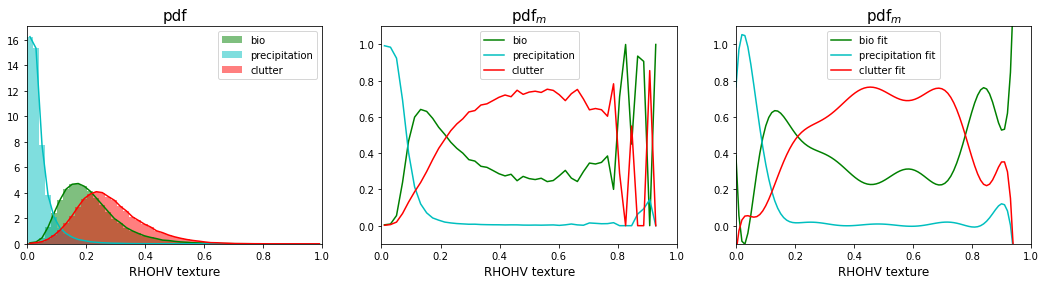

In [33]:
fig, axs = plt.subplots(1, 3, figsize=(18,4))

### RHOHV tex
data_b = RHOHV_tex_b[filter_b]
data_b = data_b[np.isfinite(data_b)]
data_p = RHOHV_tex_p[filter_p]
data_p = data_p[np.isfinite(data_p)]
data_c = RHOHV_tex_c[filter_c]
data_c = data_c[np.isfinite(data_c)]

bins = np.linspace(0, 1, 50)
bins2 = np.zeros((len(bins)-1,1))
for i in np.arange(0,len(bins)-1):
    bins2[i] = (bins[i+1] + bins[i])/2
    
ax0 = axs[0]
hb = ax0.hist(data_b, bins, label = 'bio', density=True, alpha = 0.5, color='g')
ax0.plot(bins2,hb[0],color='g')
hp = ax0.hist(data_p, bins, label = 'precipitation', density=True, alpha = 0.5, color='c')
ax0.plot(bins2,hp[0],color='c')
hc = ax0.hist(data_c, bins, label = 'clutter', density=True, alpha = 0.5, color='r')
ax0.plot(bins2,hc[0],color='r')

ax0.legend(fontsize = 10)
ax0.set_title('pdf',fontsize = 15)
ax0.set_xlabel('RHOHV texture',fontsize = 12)
ax0.set_xlim(0,1)


### part 2
h_sum = hb[0] + hp[0] + hc[0]
hb_m = hb[0]/h_sum
hp_m = hp[0]/h_sum
hc_m = hc[0]/h_sum

x = bins2.flatten()

x_b = x[~np.isnan(hb_m)]
y_b = hb_m[~np.isnan(hb_m)]
z_b = np.polyfit(x_b, y_b, 10)

x_p = x[~np.isnan(hp_m)]
y_p = hp_m[~np.isnan(hp_m)]
z_p = np.polyfit(x_p, y_p, 10)

x_c = x[~np.isnan(hc_m)]
y_c = hc_m[~np.isnan(hc_m)]
z_c = np.polyfit(x_c, y_c, 10)

p_rhot_b = np.poly1d(z_b)
p_rhot_p = np.poly1d(z_p)
p_rhot_c = np.poly1d(z_c)

xn = np.linspace(0, 1, 100)
ax0 = axs[1]
ax0.plot(bins2,hb_m, color='g', label = 'bio')
ax0.plot(bins2,hp_m, color='c', label = 'precipitation')
ax0.plot(bins2,hc_m, color='r', label = 'clutter')
#ax0.plot(xn, p_b(xn), 'g--', label='birds fit')
#ax0.plot(xn, p_i(xn), 'y--', label='insects fit')
#ax0.plot(xn, p_p(xn), 'c--', label='precipitation fit')
ax0.legend(fontsize = 10)
ax0.set_title('pdf$_m$',fontsize = 15)
ax0.set_xlabel('RHOHV texture',fontsize = 12)
ax0.set_ylim(-0.1,1.1)
ax0.set_xlim(0,1)


### part 3
ax0 = axs[2]
ax0.plot(xn, p_rhot_b(xn), 'g-', label='bio fit')
ax0.plot(xn, p_rhot_p(xn), 'c-', label='precipitation fit')
ax0.plot(xn, p_rhot_c(xn), 'r-', label='clutter fit')
ax0.legend(fontsize = 10)
ax0.set_title('pdf$_m$',fontsize = 15)
ax0.set_xlabel('RHOHV texture',fontsize = 12)
ax0.set_ylim(-0.1,1.1)
ax0.set_xlim(0,1)

### overlap
A_rhot = histogram_intersection(hb[0],hp[0],hc[0])*(hb[1][1]-hb[1][0])
print('overlapping area = ',A_rhot)

#plt.tight_layout()
#plt.savefig(OUT_PATH + 'membership_RHOt', facecolor='white')

#### DR

overlapping area =  0.10118230891828223


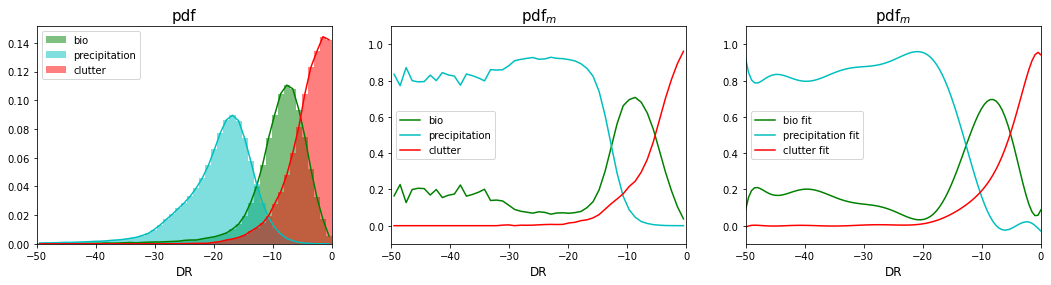

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(18,4))

### DR
data_b = DR_b[filter_b]
data_b = data_b[np.isfinite(data_b)]
data_p = DR_p[filter_p]
data_p = data_p[np.isfinite(data_p)]
data_c = DR_c[filter_c]
data_c = data_c[np.isfinite(data_c)]

bins = np.linspace(-50, 0, 50)
bins2 = np.zeros((len(bins)-1,1))
for i in np.arange(0,len(bins)-1):
    bins2[i] = (bins[i+1] + bins[i])/2
    
ax0 = axs[0]
hb = ax0.hist(data_b, bins, label = 'bio', density=True, alpha = 0.5, color='g')
ax0.plot(bins2,hb[0],color='g')
hp = ax0.hist(data_p, bins, label = 'precipitation', density=True, alpha = 0.5, color='c')
ax0.plot(bins2,hp[0],color='c')
hc = ax0.hist(data_c, bins, label = 'clutter', density=True, alpha = 0.5, color='r')
ax0.plot(bins2,hc[0],color='r')

ax0.legend(fontsize = 10)
ax0.set_title('pdf',fontsize = 15)
ax0.set_xlabel('DR',fontsize = 12)
ax0.set_xlim(-50,0)


### part 2
h_sum = hb[0] + hp[0] + hc[0]
hb_m = hb[0]/h_sum
hp_m = hp[0]/h_sum
hc_m = hc[0]/h_sum

x = bins2.flatten()

x_b = x[~np.isnan(hb_m)]
y_b = hb_m[~np.isnan(hb_m)]
z_b = np.polyfit(x_b, y_b, 10)

x_p = x[~np.isnan(hp_m)]
y_p = hp_m[~np.isnan(hp_m)]
z_p = np.polyfit(x_p, y_p, 10)

x_c = x[~np.isnan(hc_m)]
y_c = hc_m[~np.isnan(hc_m)]
z_c = np.polyfit(x_c, y_c, 10)

p_dr_b = np.poly1d(z_b)
p_dr_p = np.poly1d(z_p)
p_dr_c = np.poly1d(z_c)

xn = np.linspace(-50, 0, 100)
ax0 = axs[1]
ax0.plot(bins2,hb_m, color='g', label = 'bio')
ax0.plot(bins2,hp_m, color='c', label = 'precipitation')
ax0.plot(bins2,hc_m, color='r', label = 'clutter')
#ax0.plot(xn, p_b(xn), 'g--', label='birds fit')
#ax0.plot(xn, p_i(xn), 'y--', label='insects fit')
#ax0.plot(xn, p_p(xn), 'c--', label='precipitation fit')
ax0.legend(fontsize = 10)
ax0.set_title('pdf$_m$',fontsize = 15)
ax0.set_xlabel('DR',fontsize = 12)
ax0.set_ylim(-0.1,1.1)
ax0.set_xlim(-50,0)


### part 3
ax0 = axs[2]
ax0.plot(xn, p_dr_b(xn), 'g-', label='bio fit')
ax0.plot(xn, p_dr_p(xn), 'c-', label='precipitation fit')
ax0.plot(xn, p_dr_c(xn), 'r-', label='clutter fit')
ax0.legend(fontsize = 10)
ax0.set_title('pdf$_m$',fontsize = 15)
ax0.set_xlabel('DR',fontsize = 12)
ax0.set_ylim(-0.1,1.1)
ax0.set_xlim(-50,0)

### overlap
A_dr = histogram_intersection(hb[0],hp[0],hc[0])*(hb[1][1]-hb[1][0])
print('overlapping area = ',A_dr)

#plt.tight_layout()
#plt.savefig(OUT_PATH + 'membership_DR', facecolor='white')

#### VRAD texture

overlapping area =  0.2304987673953388


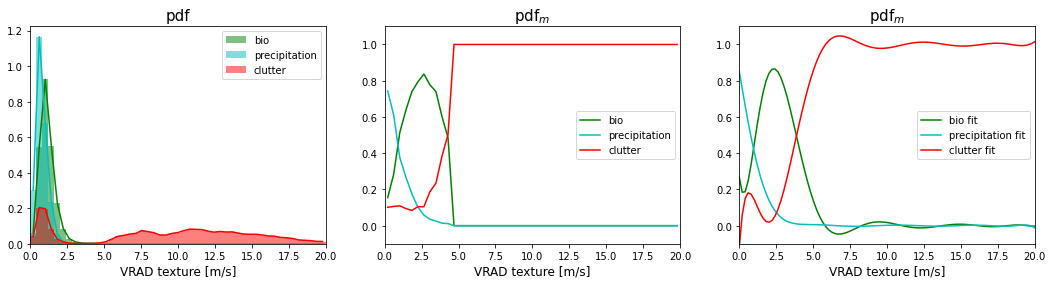

In [35]:
fig, axs = plt.subplots(1, 3, figsize=(18,4))

### WRAD
data_b = VRAD_tex_b[filter_b]
data_b = data_b[np.isfinite(data_b)]
data_p = VRAD_tex_p[filter_p]
data_p = data_p[np.isfinite(data_p)]
data_c = VRAD_tex_c[filter_c]
data_c = data_c[np.isfinite(data_c)]

bins = np.linspace(0, 20, 50)
bins2 = np.zeros((len(bins)-1,1))
for i in np.arange(0,len(bins)-1):
    bins2[i] = (bins[i+1] + bins[i])/2
    
ax0 = axs[0]
hb = ax0.hist(data_b, bins, label = 'bio', density=True, alpha = 0.5, color='g')
ax0.plot(bins2,hb[0],color='g')
hp = ax0.hist(data_p, bins, label = 'precipitation', density=True, alpha = 0.5, color='c')
ax0.plot(bins2,hp[0],color='c')
hc = ax0.hist(data_c, bins, label = 'clutter', density=True, alpha = 0.5, color='r')
ax0.plot(bins2,hc[0],color='r')

ax0.legend(fontsize = 10)
ax0.set_title('pdf',fontsize = 15)
ax0.set_xlabel('VRAD texture [m/s]',fontsize = 12)
ax0.set_xlim(0,20)


### part 2
h_sum = hb[0] + hp[0] + hc[0]
hb_m = hb[0]/h_sum
hp_m = hp[0]/h_sum
hc_m = hc[0]/h_sum

x = bins2.flatten()

x_b = x[~np.isnan(hb_m)]
y_b = hb_m[~np.isnan(hb_m)]
z_b = np.polyfit(x_b, y_b, 10)

x_p = x[~np.isnan(hp_m)]
y_p = hp_m[~np.isnan(hp_m)]
z_p = np.polyfit(x_p, y_p, 10)

x_c = x[~np.isnan(hc_m)]
y_c = hc_m[~np.isnan(hc_m)]
z_c = np.polyfit(x_c, y_c, 10)

p_vradt_b = np.poly1d(z_b)
p_vradt_p = np.poly1d(z_p)
p_vradt_c = np.poly1d(z_c)

xn = np.linspace(0, 20, 100)
ax0 = axs[1]
ax0.plot(bins2,hb_m, color='g', label = 'bio')
ax0.plot(bins2,hp_m, color='c', label = 'precipitation')
ax0.plot(bins2,hc_m, color='r', label = 'clutter')
#ax0.plot(xn, p_b(xn), 'g--', label='birds fit')
#ax0.plot(xn, p_i(xn), 'y--', label='insects fit')
#ax0.plot(xn, p_p(xn), 'c--', label='precipitation fit')
ax0.legend(fontsize = 10)
ax0.set_title('pdf$_m$',fontsize = 15)
ax0.set_xlabel('VRAD texture [m/s]',fontsize = 12)
ax0.set_ylim(-0.1,1.1)
ax0.set_xlim(0,20)


### part 3
ax0 = axs[2]
ax0.plot(xn, p_vradt_b(xn), 'g-', label='bio fit')
ax0.plot(xn, p_vradt_p(xn), 'c-', label='precipitation fit')
ax0.plot(xn, p_vradt_c(xn), 'r-', label='clutter fit')
ax0.legend(fontsize = 10)
ax0.set_title('pdf$_m$',fontsize = 15)
ax0.set_xlabel('VRAD texture [m/s]',fontsize = 12)
ax0.set_ylim(-0.1,1.1)
ax0.set_xlim(0,20)

### overlap
A_vradt = histogram_intersection(hb[0],hp[0],hc[0])*(hb[1][1]-hb[1][0])
print('overlapping area = ',A_vradt)

#plt.tight_layout()
#plt.savefig(OUT_PATH + 'membership_VRADt', facecolor='white')

#### WRAD

overlapping area =  0.6044605357473148


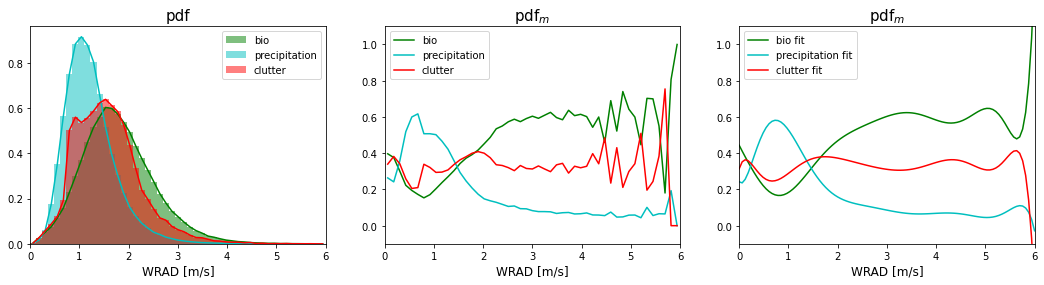

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(18,4))

### WRAD
data_b = WRAD_b[filter_b]
data_b = data_b[np.isfinite(data_b)]
data_p = WRAD_p[filter_p]
data_p = data_p[np.isfinite(data_p)]
data_c = WRAD_c[filter_c]
data_c = data_c[np.isfinite(data_c)]

bins = np.linspace(0, 6, 50)
bins2 = np.zeros((len(bins)-1,1))
for i in np.arange(0,len(bins)-1):
    bins2[i] = (bins[i+1] + bins[i])/2
    
ax0 = axs[0]
hb = ax0.hist(data_b, bins, label = 'bio', density=True, alpha = 0.5, color='g')
ax0.plot(bins2,hb[0],color='g')
hp = ax0.hist(data_p, bins, label = 'precipitation', density=True, alpha = 0.5, color='c')
ax0.plot(bins2,hp[0],color='c')
hc = ax0.hist(data_c, bins, label = 'clutter', density=True, alpha = 0.5, color='r')
ax0.plot(bins2,hc[0],color='r')

ax0.legend(fontsize = 10)
ax0.set_title('pdf',fontsize = 15)
ax0.set_xlabel('WRAD [m/s]',fontsize = 12)
ax0.set_xlim(0,6)


### part 2
h_sum = hb[0] + hp[0] + hc[0]
hb_m = hb[0]/h_sum
hp_m = hp[0]/h_sum
hc_m = hc[0]/h_sum

x = bins2.flatten()

x_b = x[~np.isnan(hb_m)]
y_b = hb_m[~np.isnan(hb_m)]
z_b = np.polyfit(x_b, y_b, 10)

x_p = x[~np.isnan(hp_m)]
y_p = hp_m[~np.isnan(hp_m)]
z_p = np.polyfit(x_p, y_p, 10)

x_c = x[~np.isnan(hc_m)]
y_c = hc_m[~np.isnan(hc_m)]
z_c = np.polyfit(x_c, y_c, 10)

p_wrad_b = np.poly1d(z_b)
p_wrad_p = np.poly1d(z_p)
p_wrad_c = np.poly1d(z_c)

xn = np.linspace(0, 6, 100)
ax0 = axs[1]
ax0.plot(bins2,hb_m, color='g', label = 'bio')
ax0.plot(bins2,hp_m, color='c', label = 'precipitation')
ax0.plot(bins2,hc_m, color='r', label = 'clutter')
#ax0.plot(xn, p_b(xn), 'g--', label='birds fit')
#ax0.plot(xn, p_i(xn), 'y--', label='insects fit')
#ax0.plot(xn, p_p(xn), 'c--', label='precipitation fit')
ax0.legend(fontsize = 10)
ax0.set_title('pdf$_m$',fontsize = 15)
ax0.set_xlabel('WRAD [m/s]',fontsize = 12)
ax0.set_ylim(-0.1,1.1)
ax0.set_xlim(0,6)


### part 3
ax0 = axs[2]
ax0.plot(xn, p_wrad_b(xn), 'g-', label='bio fit')
ax0.plot(xn, p_wrad_p(xn), 'c-', label='precipitation fit')
ax0.plot(xn, p_wrad_c(xn), 'r-', label='clutter fit')
ax0.legend(fontsize = 10)
ax0.set_title('pdf$_m$',fontsize = 15)
ax0.set_xlabel('WRAD [m/s]',fontsize = 12)
ax0.set_ylim(-0.1,1.1)
ax0.set_xlim(0,6)

### overlap
A_wrad = histogram_intersection(hb[0],hp[0],hc[0])*(hb[1][1]-hb[1][0])
print('overlapping area = ',A_wrad)

#plt.tight_layout()
#plt.savefig(OUT_PATH + 'membership_WRAD', facecolor='white')

#### VGZ

overlapping area =  0.28731861010435783


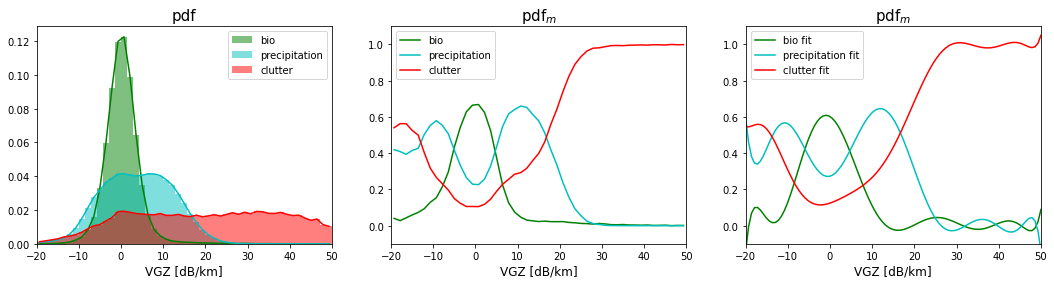

In [37]:
fig, axs = plt.subplots(1, 3, figsize=(18,4))

### VGZ
data_b = VGZ_b[filter_b]
data_b = data_b[np.isfinite(data_b)]
data_p = VGZ_p[filter_p]
data_p = data_p[np.isfinite(data_p)]
data_c = VGZ_c[filter_c]
data_c = data_c[np.isfinite(data_c)]

bins = np.linspace(-20, 50, 50)
bins2 = np.zeros((len(bins)-1,1))
for i in np.arange(0,len(bins)-1):
    bins2[i] = (bins[i+1] + bins[i])/2
    
ax0 = axs[0]
hb = ax0.hist(data_b, bins, label = 'bio', density=True, alpha = 0.5, color='g')
ax0.plot(bins2,hb[0],color='g')
hp = ax0.hist(data_p, bins, label = 'precipitation', density=True, alpha = 0.5, color='c')
ax0.plot(bins2,hp[0],color='c')
hc = ax0.hist(data_c, bins, label = 'clutter', density=True, alpha = 0.5, color='r')
ax0.plot(bins2,hc[0],color='r')

ax0.legend(fontsize = 10)
ax0.set_title('pdf',fontsize = 15)
ax0.set_xlabel('VGZ [dB/km]',fontsize = 12)
ax0.set_xlim(-20,50)


### part 2
h_sum = hb[0] + hp[0] + hc[0]
hb_m = hb[0]/h_sum
hp_m = hp[0]/h_sum
hc_m = hc[0]/h_sum

x = bins2.flatten()

x_b = x[~np.isnan(hb_m)]
y_b = hb_m[~np.isnan(hb_m)]
z_b = np.polyfit(x_b, y_b, 10)

x_p = x[~np.isnan(hp_m)]
y_p = hp_m[~np.isnan(hp_m)]
z_p = np.polyfit(x_p, y_p, 10)

x_c = x[~np.isnan(hc_m)]
y_c = hc_m[~np.isnan(hc_m)]
z_c = np.polyfit(x_c, y_c, 10)

p_vgz_b = np.poly1d(z_b)
p_vgz_p = np.poly1d(z_p)
p_vgz_c = np.poly1d(z_c)

xn = np.linspace(-20, 50, 100)
ax0 = axs[1]
ax0.plot(bins2,hb_m, color='g', label = 'bio')
ax0.plot(bins2,hp_m, color='c', label = 'precipitation')
ax0.plot(bins2,hc_m, color='r', label = 'clutter')
#ax0.plot(xn, p_b(xn), 'g--', label='birds fit')
#ax0.plot(xn, p_i(xn), 'y--', label='insects fit')
#ax0.plot(xn, p_p(xn), 'c--', label='precipitation fit')
ax0.legend(fontsize = 10)
ax0.set_title('pdf$_m$',fontsize = 15)
ax0.set_xlabel('VGZ [dB/km]',fontsize = 12)
ax0.set_ylim(-0.1,1.1)
ax0.set_xlim(-20,50)


### part 3
ax0 = axs[2]
ax0.plot(xn, p_vgz_b(xn), 'g-', label='bio fit')
ax0.plot(xn, p_vgz_p(xn), 'c-', label='precipitation fit')
ax0.plot(xn, p_vgz_c(xn), 'r-', label='clutter fit')
ax0.legend(fontsize = 10)
ax0.set_title('pdf$_m$',fontsize = 15)
ax0.set_xlabel('VGZ [dB/km]',fontsize = 12)
ax0.set_ylim(-0.1,1.1)
ax0.set_xlim(-20,50)

### overlap
A_vgz = histogram_intersection(hb[0],hp[0],hc[0])*(hb[1][1]-hb[1][0])
print('overlapping area = ',A_vgz)

#plt.tight_layout()
#plt.savefig(OUT_PATH + 'membership_VGZ', facecolor='white')

#### PHIDP texture

C:\Users\leona\anaconda3\envs\myenv\lib\site-packages\numpy\lib\histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


overlapping area =  0.5366001430667184


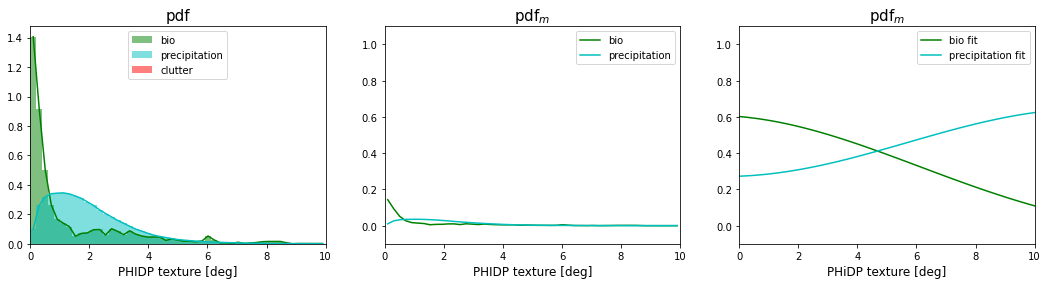

In [38]:
fig, axs = plt.subplots(1, 3, figsize=(18,4))

### PHIDP tex
data_b = PHIDP_tex_b[filter_b]
data_b = data_b[np.isfinite(data_b)]
data_p = PHIDP_tex_p[filter_p]
data_p = data_p[np.isfinite(data_p)]
data_c = PHIDP_tex_c[filter_c]
data_c = data_c[np.isfinite(data_c)]

bins = np.linspace(0, 10, 50)
bins2 = np.zeros((len(bins)-1,1))
for i in np.arange(0,len(bins)-1):
    bins2[i] = (bins[i+1] + bins[i])/2
    
ax0 = axs[0]
hb = ax0.hist(data_b, bins, label = 'bio', density=True, alpha = 0.5, color='g')
ax0.plot(bins2,hb[0],color='g')
hp = ax0.hist(data_p, bins, label = 'precipitation', density=True, alpha = 0.5, color='c')
ax0.plot(bins2,hp[0],color='c')
hc = ax0.hist(data_c, bins, label = 'clutter', density=True, alpha = 0.5, color='r')
ax0.plot(bins2,hc[0],color='r')

ax0.legend(fontsize = 10)
ax0.set_title('pdf',fontsize = 15)
ax0.set_xlabel('PHIDP texture [deg]',fontsize = 12)
ax0.set_xlim(0,10)


### part 2
h_sum = np.nansum((hb[0],hp[0],hc[0]))
hb_m = hb[0]/h_sum
hp_m = hp[0]/h_sum
hc_m = hc[0]/h_sum

x = bins2.flatten()

x_b = x[~np.isnan(hb_m)]
y_b = hb_m[~np.isnan(hb_m)]
z_b = np.polyfit(x_b, y_b, 10)

x_p = x[~np.isnan(hp_m)]
y_p = hp_m[~np.isnan(hp_m)]
z_p = np.polyfit(x_p, y_p, 10)

#x_c = x[~np.isnan(hc_m)]
#y_c = hc_m[~np.isnan(hc_m)]
#z_c = np.polyfit(x_c, y_c, 10)

p_phit_b = np.poly1d(z_b)
p_phit_p = np.poly1d(z_p)
#p_vgz_c = np.poly1d(z_c)
p_phit_c = np.copy(p_phit_b)
p_phit_c[:] = np.nan

xn = np.linspace(0, 10, 100)
ax0 = axs[1]
ax0.plot(bins2,hb_m, color='g', label = 'bio')
ax0.plot(bins2,hp_m, color='c', label = 'precipitation')
#ax0.plot(bins2,hc_m, color='r', label = 'clutter')
#ax0.plot(xn, p_b(xn), 'g--', label='birds fit')
#ax0.plot(xn, p_i(xn), 'y--', label='insects fit')
#ax0.plot(xn, p_p(xn), 'c--', label='precipitation fit')
ax0.legend(fontsize = 10)
ax0.set_title('pdf$_m$',fontsize = 15)
ax0.set_xlabel('PHIDP texture [deg]',fontsize = 12)
ax0.set_ylim(-0.1,1.1)
ax0.set_xlim(0,10)


### part 3
ax0 = axs[2]
ax0.plot(xn, p_vgz_b(xn), 'g-', label='bio fit')
ax0.plot(xn, p_vgz_p(xn), 'c-', label='precipitation fit')
#ax0.plot(xn, p_vgz_c(xn), 'r-', label='clutter fit')
ax0.legend(fontsize = 10)
ax0.set_title('pdf$_m$',fontsize = 15)
ax0.set_xlabel('PHiDP texture [deg]',fontsize = 12)
ax0.set_ylim(-0.1,1.1)
ax0.set_xlim(0,10)

### overlap
A_phit = histogram_intersection(hb[0],hp[0],hc[0])*(hb[1][1]-hb[1][0])
print('overlapping area = ',A_phit)

#plt.tight_layout()
#plt.savefig(OUT_PATH + 'membership_PHIt', facecolor='white')

### Calculate weights

#### polarimetric algortihm

In [39]:
A_sum_pol = 1/A_dbzh + 1/A_cpa + 1/A_zdrt + 1/A_rhot + 1/A_dr + 1/A_wrad + 1/A_vgz + 1/A_vradt #+ 1/A_phit

w_dbzh_pol = 1/A_dbzh * 1/A_sum_pol
w_cpa_pol  = 1/A_cpa  * 1/A_sum_pol
w_zdrt_pol = 1/A_zdrt * 1/A_sum_pol
w_rhot_pol = 1/A_rhot * 1/A_sum_pol
w_dr_pol   = 1/A_dr   * 1/A_sum_pol
w_wrad_pol = 1/A_wrad * 1/A_sum_pol
w_vgz_pol  = 1/A_vgz  * 1/A_sum_pol
w_vradt_pol = 1/A_vradt * 1/A_sum_pol
#w_phit_pol = 1/A_phit * 1/A_sum_pol

print('W dbzh =', w_dbzh_pol)
print('W cpa =', w_cpa_pol)
print('W zdrt =',w_zdrt_pol)
print('W rhot =',w_rhot_pol)
print('W dr =',w_dr_pol)
print('W wrad =',w_wrad_pol)
print('W vgz =',w_vgz_pol)
print('W vradt =',w_vradt_pol)
#print('W phit =',w_phit_pol)

w_sum_pol = w_dbzh_pol + w_cpa_pol + w_zdrt_pol + w_rhot_pol + w_dr_pol + w_wrad_pol + w_vgz_pol + w_vradt_pol #+ w_phit_pol

W dbzh = 0.15143688593551777
W cpa = 0.15738835973580131
W zdrt = 0.19886529387804056
W rhot = 0.16661931513384204
W dr = 0.16629362434813755
W wrad = 0.027836346419425905
W vgz = 0.05856207108833856
W vradt = 0.07299810346089637


#### non-polarimetric algortihm

In [40]:
A_sum = 1/A_dbzh + 1/A_cpa + 1/A_wrad + 1/A_vgz + 1/A_vradt

w_dbzh = 1/A_dbzh * 1/A_sum
w_cpa  = 1/A_cpa  * 1/A_sum
w_wrad = 1/A_wrad * 1/A_sum
w_vgz  = 1/A_vgz  * 1/A_sum
w_vradt = 1/A_vradt * 1/A_sum

print('W dbzh =', w_dbzh)
print('W cpa =', w_cpa)
print('W wrad =',w_wrad)
print('W vgz =',w_vgz)
print('W vradt =',w_vradt)

w_sum = w_dbzh + w_cpa + w_wrad + w_vgz + w_vradt

W dbzh = 0.32342982903645956
W cpa = 0.336140630251431
W wrad = 0.05945120112459345
W vgz = 0.12507336322398585
W vradt = 0.1559049763635301


### Calculate aggreation values

Formula for aggregation values Q:

Q$_i$ = sum [pdf$_m$$^i$(x$_j$) w$_j$] / sum(w$_j$)

$i$ varies over bio, precipitation, and clutter

$j$ refers to different variables (and memebership functions)

### Classification

In [44]:
def func_classi_pol(radfile, dataset_idx):
    
    radar = 'NLHRW'
    map_date = '20190218'
    map_var = 'TH'
    
    #extract variables
    f = OdimH5File(radfile)
    DBZH, VGZ, ZDR, ZDR_tex, RHOHV, RHOHV_tex, DR, PHIDP, PHIDP_tex, KDP, VRAD, VRAD_tex, VRAD_std, WRAD, CPA, clu_map, rad_lat, rad_lon, RR, TT = extract_variables(f,radar,dataset_idx,map_date,map_var)
    
    #calcualte aggregation values
    Q_b = np.sum([p_dbzh_b(DBZH)*w_dbzh_pol,
                  np.nansum([p_cpa_b(CPA)*w_cpa_pol, 
                             p_zdrt_b(ZDR_tex)*w_zdrt_pol, 
                             p_rhot_b(RHOHV_tex)*w_rhot_pol,
                             p_dr_b(DR)*w_dr_pol,
                             p_wrad_b(WRAD)*w_wrad_pol,
                             p_vgz_b(VGZ)*w_vgz_pol, 
                             p_vradt_b(VRAD_tex)*w_vradt_pol,
                             #p_phit_b(PHIDP_tex)*w_phit_pol, 
                            ],axis=0)
                  ],axis=0)/w_sum_pol 
    
    Q_p = np.sum([p_dbzh_p(DBZH)*w_dbzh_pol,
                  np.nansum([p_cpa_p(CPA)*w_cpa_pol, 
                             p_zdrt_p(ZDR_tex)*w_zdrt_pol, 
                             p_rhot_p(RHOHV_tex)*w_rhot_pol,
                             p_dr_p(DR)*w_dr_pol,
                             p_wrad_p(WRAD)*w_wrad_pol,
                             p_vgz_p(VGZ)*w_vgz_pol, 
                             p_vradt_p(VRAD_tex)*w_vradt_pol,
                             #p_phit_p(PHIDP_tex)*w_phit_pol, 
                            ],axis=0)
                 ],axis=0)/w_sum_pol 
    
    Q_c = np.sum([p_dbzh_c(DBZH)*w_dbzh_pol,
                  np.nansum([p_cpa_c(CPA)*w_cpa_pol, 
                             p_zdrt_c(ZDR_tex)*w_zdrt_pol, 
                             p_rhot_c(RHOHV_tex)*w_rhot_pol,
                             p_dr_c(DR)*w_dr_pol,
                             p_wrad_c(WRAD)*w_wrad_pol,
                             p_vgz_c(VGZ)*w_vgz_pol, 
                             p_vradt_c(VRAD_tex)*w_vradt_pol,
                             #p_phit_c(PHIDP_tex)*w_phit_pol, 
                            ],axis=0)
                 ],axis=0)/w_sum_pol 
    
    #set threshold for each class to imporve classification
    filter_bio = np.any([clu_map>=0,
                         DBZH>30,
                         RR<5000,
                         ZDR_tex<=0.7,
                        ],axis=0)

    filter_prec = np.any([clu_map>=0,
                          RR<5000,
                          RHOHV<0.8,
                          ZDR_tex>=3,
                          ZDR>4,
                          ZDR<-2,
                         ],axis=0)

    filter_clu = np.any([np.absolute(VRAD>3),
                         #VRAD_tex>5,
                         WRAD>3,
                         RHOHV>0.85,
                         DR<-12,
                         VGZ<-10,
                         #~np.isnan(PHIDP_tex),
                        ],axis=0)

    Q_b[filter_bio] = np.nan
    Q_p[filter_prec] = np.nan
    Q_c[filter_clu] = np.nan
    
    
    #
    QQ = np.copy(Q_b)
    QQ[:] = np.nan
    QQ = np.fmax.reduce((Q_b,Q_p,Q_c))   #fmax finds maximim of two arrays elementwise, ignoring NaNs, 
                                         #reduce is to use more than two arrays


    classi = np.copy(Q_b)
    classi[:] = np.nan

    for i in np.arange(0,np.shape(QQ)[0]):
        for j in np.arange(0,np.shape(QQ)[1]):

            if (QQ[i,j] == Q_b[i,j]):
                classi[i,j] = 1

            elif (QQ[i,j] == Q_p[i,j]):
                classi[i,j] = 2

            elif (QQ[i,j] == Q_c[i,j]):
                classi[i,j] = 3

   
    
    ### Plot figures
    fig, axs = plt.subplots(1, 2, figsize=(18,7))
    cmap = plt.get_cmap()

    ### DBZH
    ax = axs[0]
    ax, pm = wradlib.vis.plot_ppi(DBZH, ax=ax)
    plt.xlim(-500,500)
    plt.ylim(-500,500)
    plt.xlabel("# bins from radar", fontsize = 12)
    plt.ylabel("# bins from radar", fontsize = 12)
    cbar = plt.colorbar(pm) #, shrink=0.3)
    cbar.set_label("dBZ", fontsize = 14)

    ### classi
    ax = axs[1]
    cmap2 = (mpl.colors.ListedColormap(['green', 'cyan', 'red']))

    ax, pm = wradlib.vis.plot_ppi(classi, ax=ax, cmap=cmap2)
    plt.xlim(-500,500)
    plt.ylim(-500,500)
    plt.xlabel("# bins from radar", fontsize = 12)
    plt.ylabel("# bins from radar", fontsize = 12)

    cbar = plt.colorbar(pm, ax=ax, ticks=(1.35,2,2.65))
    cbar.set_ticklabels(['bio', 'precipitation', 'clutter']) 
    
    f.close()
    
    return classi

In [45]:
def func_classi(radfile, dataset_idx):
    
    radar = 'NLHRW'
    map_date = '20190218'
    map_var = 'TH'
    
    #extract variables
    f = OdimH5File(radfile)
    DBZH, VGZ, ZDR, ZDR_tex, RHOHV, RHOHV_tex, DR, PHIDP, PHIDP_tex, KDP, VRAD, VRAD_tex, VRAD_std, WRAD, CPA, clu_map, rad_lat, rad_lon, RR, TT = extract_variables(f,radar,dataset_idx,map_date,map_var)
    
    #calcualte aggregation values
    Q_b = np.sum([p_dbzh_b(DBZH)*w_dbzh,
                  np.nansum([p_cpa_b(CPA)*w_cpa, 
                             p_wrad_b(WRAD)*w_wrad,
                             p_vgz_b(VGZ)*w_vgz,
                             p_vradt_b(VRAD_tex)*w_vradt,
                            ],axis=0)
                  ],axis=0)/w_sum 
    
    Q_p = np.sum([p_dbzh_p(DBZH)*w_dbzh,
                  np.nansum([p_cpa_p(CPA)*w_cpa, 
                             p_wrad_p(WRAD)*w_wrad,
                             p_vgz_p(VGZ)*w_vgz, 
                             p_vradt_p(VRAD_tex)*w_vradt,
                            ],axis=0)
                 ],axis=0)/w_sum 
    
    Q_c = np.sum([p_dbzh_c(DBZH)*w_dbzh,
                  np.nansum([p_cpa_c(CPA)*w_cpa, 
                             p_wrad_c(WRAD)*w_wrad,
                             p_vgz_c(VGZ)*w_vgz, 
                             p_vradt_c(VRAD_tex)*w_vradt,
                            ],axis=0)
                 ],axis=0)/w_sum 
    
    #set threshold for each class to imporve classification
    filter_bio = np.any([clu_map>=0,
                         RR<5000,
                         DBZH>30,
                         #VRAD_tex>5,
                        ],axis=0)

    filter_prec = np.any([clu_map>=0,
                          RR<5000,
                          #RHOHV<0.8,
                          #ZDR>4,
                          #ZDR<-2,
                         ],axis=0)

    filter_clu = np.any([np.absolute(VRAD>3),
                         WRAD>3,
                         #RHOHV>0.85,
                         #DR<-12,
                         VGZ<-10,
                        ],axis=0)

    Q_b[filter_bio] = np.nan
    Q_p[filter_prec] = np.nan
    Q_c[filter_clu] = np.nan
    
    
    #
    QQ = np.copy(Q_b)
    QQ[:] = np.nan
    QQ = np.fmax.reduce((Q_b,Q_p,Q_c))   #fmax finds maximim of two arrays elementwise, ignoring NaNs, 
                                         #reduce is to use more than two arrays


    classi = np.copy(Q_b)
    classi[:] = np.nan

    for i in np.arange(0,np.shape(QQ)[0]):
        for j in np.arange(0,np.shape(QQ)[1]):

            if (QQ[i,j] == Q_b[i,j]):
                classi[i,j] = 1

            elif (QQ[i,j] == Q_p[i,j]):
                classi[i,j] = 2

            elif (QQ[i,j] == Q_c[i,j]):
                classi[i,j] = 3

            
    #plot figures
    fig, axs = plt.subplots(1, 2, figsize=(18,7))
    cmap = plt.get_cmap()

    ### DBZH
    ax = axs[0]
    ax, pm = wradlib.vis.plot_ppi(DBZH, ax=ax)
    plt.xlim(-500,500)
    plt.ylim(-500,500)
    plt.xlabel("# bins from radar", fontsize = 12)
    plt.ylabel("# bins from radar", fontsize = 12)
    cbar = plt.colorbar(pm) #, shrink=0.3)
    cbar.set_label("dBZ", fontsize = 14)

    ### classi
    ax = axs[1]
    cmap2 = (mpl.colors.ListedColormap(['green', 'cyan', 'red']))

    ax, pm = wradlib.vis.plot_ppi(classi, ax=ax, cmap=cmap2)
    plt.xlim(-500,500)
    plt.ylim(-500,500)
    plt.xlabel("# bins from radar", fontsize = 12)
    plt.ylabel("# bins from radar", fontsize = 12)

    cbar = plt.colorbar(pm, ax=ax, ticks=(1.35,2,2.65))
    cbar.set_ticklabels(['bio', 'precipitation', 'clutter']) 
    
    f.close()
    
    return classi

### Application of classification algorithms (polarimetric and non-polarimetric)

C:/Users/leona/Desktop/Data/NLHRW_pvol_20200316T1900_6356.h5


C:\Users\leona\AppData\Local\Temp/ipykernel_5912/1637127489.py:5: RuntimeWarning: invalid value encountered in log10
  DR = 10*np.log10(Dr)
C:\Users\leona\anaconda3\envs\myenv\lib\site-packages\wradlib\dp.py:560: RuntimeWarning: invalid value encountered in true_divide
  rmsd = np.sqrt(np.nansum((xa - data) ** 2, axis=0) / xa_valid_count)
C:\Users\leona\AppData\Local\Temp/ipykernel_5912/1637127489.py:5: RuntimeWarning: invalid value encountered in log10
  DR = 10*np.log10(Dr)
C:\Users\leona\anaconda3\envs\myenv\lib\site-packages\wradlib\dp.py:560: RuntimeWarning: invalid value encountered in true_divide
  rmsd = np.sqrt(np.nansum((xa - data) ** 2, axis=0) / xa_valid_count)


array([[ 3.,  3.,  3., ..., nan, nan, nan],
       [ 3.,  3.,  3., ..., nan, nan, nan],
       [ 3.,  3.,  3., ..., nan, nan, nan],
       ...,
       [ 3.,  3.,  3., ..., nan, nan, nan],
       [ 3.,  3.,  3., ..., nan, nan, nan],
       [ 3.,  3.,  3., ..., nan, nan, nan]])

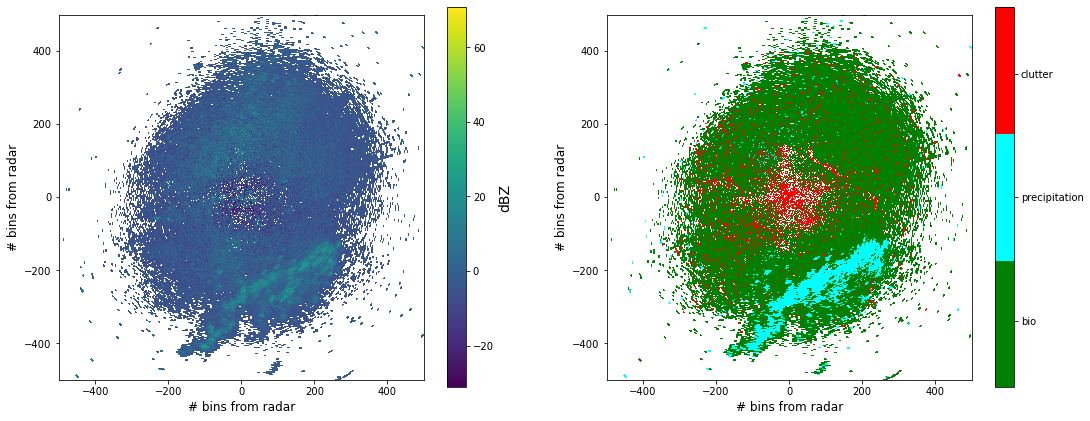

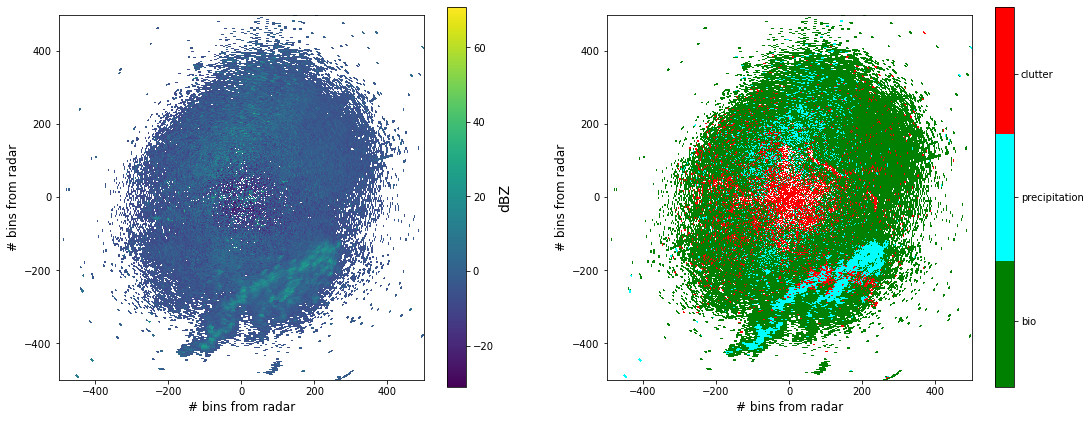

In [48]:
### NLHRW 16/03/2020 19:00
data_path = "C:/Users/leona/Desktop/Data/" #path to where pvols are
files = sorted(glob.glob(data_path + 'NLHRW_pvol_20200316T1900_6356.h5'))
radfile = files[0]
dataset_idx = 6 #ele = 0.8 deg
print(radfile)

func_classi_pol(radfile, dataset_idx)
#plt.tight_layout()
#plt.savefig(OUT_PATH + 'classi_pol_NLHRW_20200316_1900', facecolor='white')

func_classi(radfile, dataset_idx)
#plt.tight_layout()
#plt.savefig(OUT_PATH + 'classi_NLHRW_20200316_1900', facecolor='white')

C:/Users/leona/Desktop/Data/NLHRW_pvol_20200315T2330_6356.h5


C:\Users\leona\AppData\Local\Temp/ipykernel_5912/1637127489.py:5: RuntimeWarning: invalid value encountered in log10
  DR = 10*np.log10(Dr)
C:\Users\leona\anaconda3\envs\myenv\lib\site-packages\wradlib\dp.py:560: RuntimeWarning: invalid value encountered in true_divide
  rmsd = np.sqrt(np.nansum((xa - data) ** 2, axis=0) / xa_valid_count)
C:\Users\leona\AppData\Local\Temp/ipykernel_5912/1637127489.py:5: RuntimeWarning: invalid value encountered in log10
  DR = 10*np.log10(Dr)
C:\Users\leona\anaconda3\envs\myenv\lib\site-packages\wradlib\dp.py:560: RuntimeWarning: invalid value encountered in true_divide
  rmsd = np.sqrt(np.nansum((xa - data) ** 2, axis=0) / xa_valid_count)


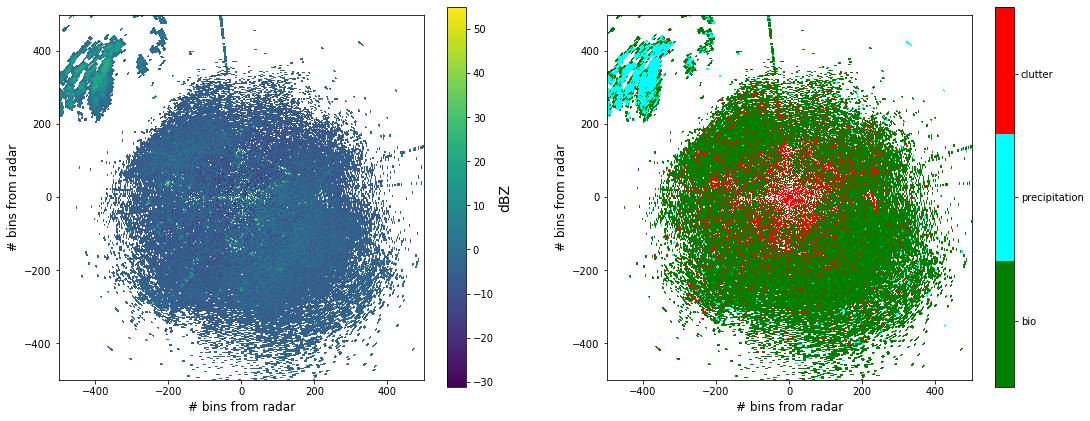

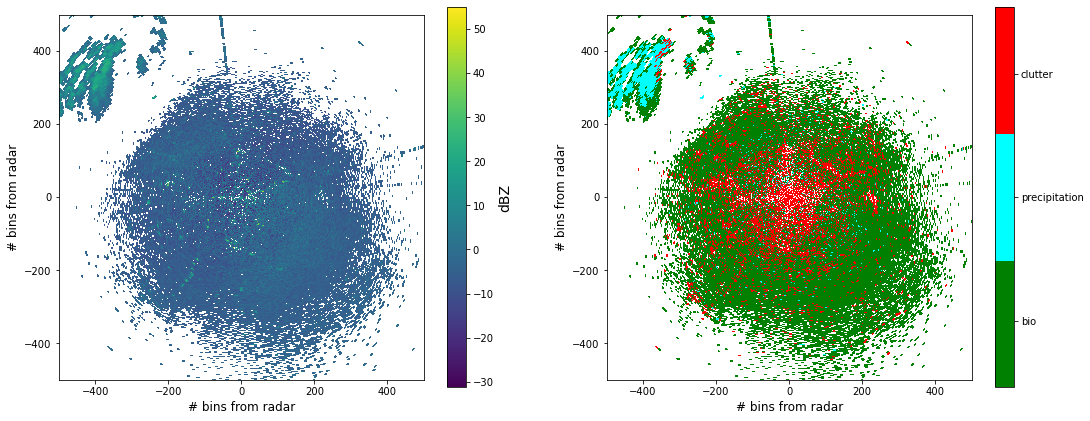

In [47]:
### NLDHL 15/03/2020 23:30
data_path = "C:/Users/leona/Desktop/Data/" #path to where pvols are
files = sorted(glob.glob(data_path + 'NLHRW_pvol_20200315T2330_6356.h5'))
radfile = files[0]
dataset_idx = 6
print(radfile)

func_classi_pol(radfile, dataset_idx)
#plt.tight_layout()
#plt.savefig(OUT_PATH + 'classi_pol_NLHRW_20200315_2330', facecolor='white')

func_classi(radfile, dataset_idx)
#plt.tight_layout()
#plt.savefig(OUT_PATH + 'classi_NLHRW_20200315_2330', facecolor='white')

C:/Users/leona/Desktop/Data/NLHRW_pvol_20200218T2045_6356.h5


C:\Users\leona\AppData\Local\Temp/ipykernel_5912/1637127489.py:5: RuntimeWarning: invalid value encountered in log10
  DR = 10*np.log10(Dr)
C:\Users\leona\anaconda3\envs\myenv\lib\site-packages\wradlib\dp.py:560: RuntimeWarning: invalid value encountered in true_divide
  rmsd = np.sqrt(np.nansum((xa - data) ** 2, axis=0) / xa_valid_count)
C:\Users\leona\AppData\Local\Temp/ipykernel_5912/1637127489.py:5: RuntimeWarning: invalid value encountered in log10
  DR = 10*np.log10(Dr)
C:\Users\leona\anaconda3\envs\myenv\lib\site-packages\wradlib\dp.py:560: RuntimeWarning: invalid value encountered in true_divide
  rmsd = np.sqrt(np.nansum((xa - data) ** 2, axis=0) / xa_valid_count)


array([[ 3.,  3.,  3., ..., nan, nan, nan],
       [ 3.,  3.,  3., ..., nan, nan, nan],
       [ 3.,  3.,  3., ..., nan, nan, nan],
       ...,
       [ 3.,  3.,  3., ...,  1., nan, nan],
       [ 3.,  3.,  3., ..., nan, nan, nan],
       [ 3.,  3.,  3., ..., nan, nan, nan]])

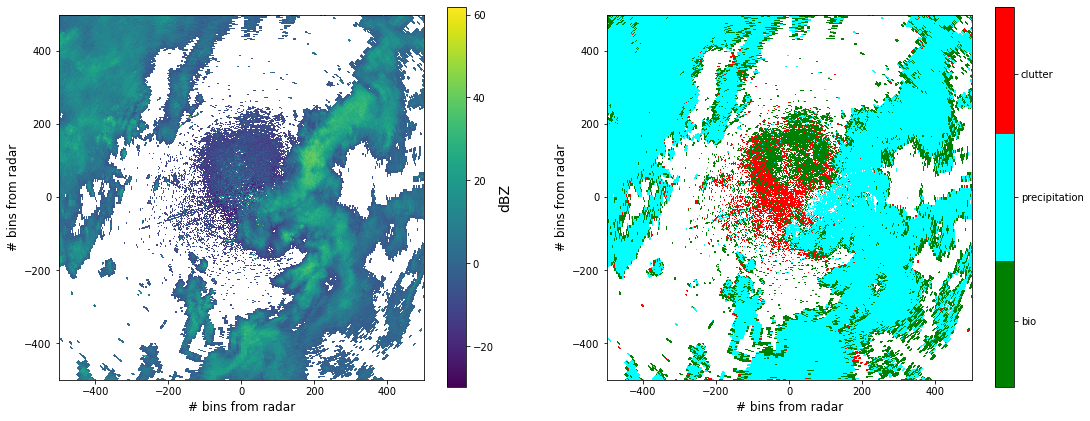

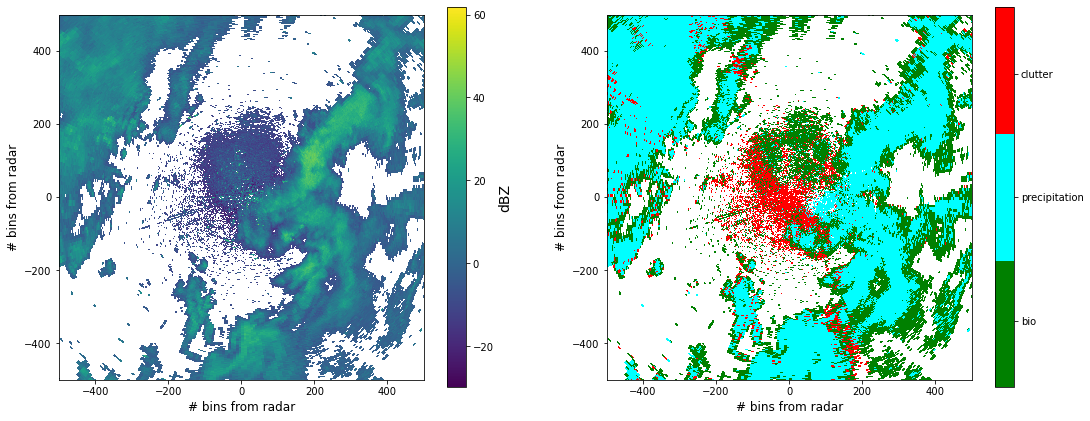

In [49]:
### NLDHL 18/02/2020 20:45
data_path = "C:/Users/leona/Desktop/Data/"
files = sorted(glob.glob(data_path + 'NLHRW_pvol_20200218T2045_6356.h5'))
radfile = files[0]
dataset_idx = 6
print(radfile)

func_classi_pol(radfile, dataset_idx)
#plt.tight_layout()
#plt.savefig(OUT_PATH + 'classi_pol_NLHRW_20200218_2045', facecolor='white')

func_classi(radfile, dataset_idx)
#plt.tight_layout()
#plt.savefig(OUT_PATH + 'classi_NLHRW_20200218_2045', facecolor='white')

### Validation

C:/Users/leona/Desktop/Data/NLHRW_pvol_20190218T1415_6356.h5


C:\Users\leona\AppData\Local\Temp/ipykernel_5912/1637127489.py:5: RuntimeWarning: invalid value encountered in log10
  DR = 10*np.log10(Dr)
C:\Users\leona\anaconda3\envs\myenv\lib\site-packages\wradlib\dp.py:560: RuntimeWarning: invalid value encountered in true_divide
  rmsd = np.sqrt(np.nansum((xa - data) ** 2, axis=0) / xa_valid_count)
C:\Users\leona\AppData\Local\Temp/ipykernel_5912/1637127489.py:5: RuntimeWarning: invalid value encountered in log10
  DR = 10*np.log10(Dr)
C:\Users\leona\anaconda3\envs\myenv\lib\site-packages\wradlib\dp.py:560: RuntimeWarning: invalid value encountered in true_divide
  rmsd = np.sqrt(np.nansum((xa - data) ** 2, axis=0) / xa_valid_count)


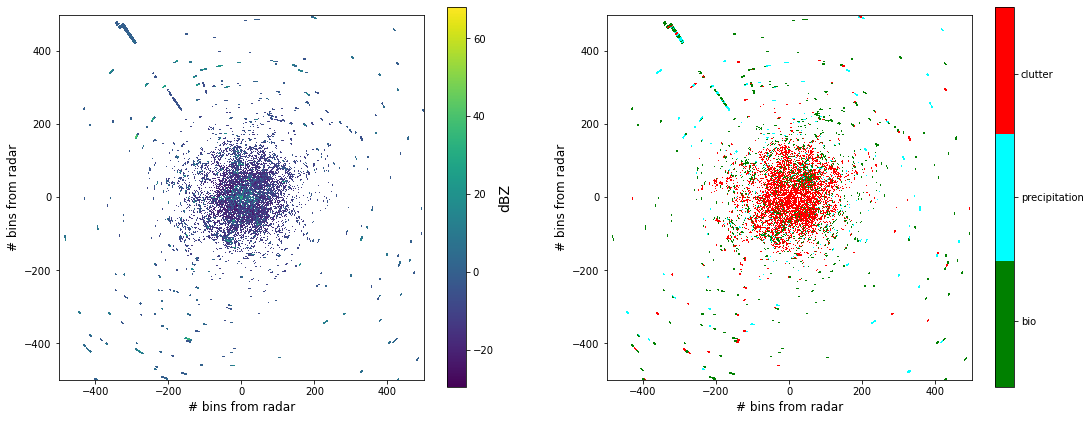

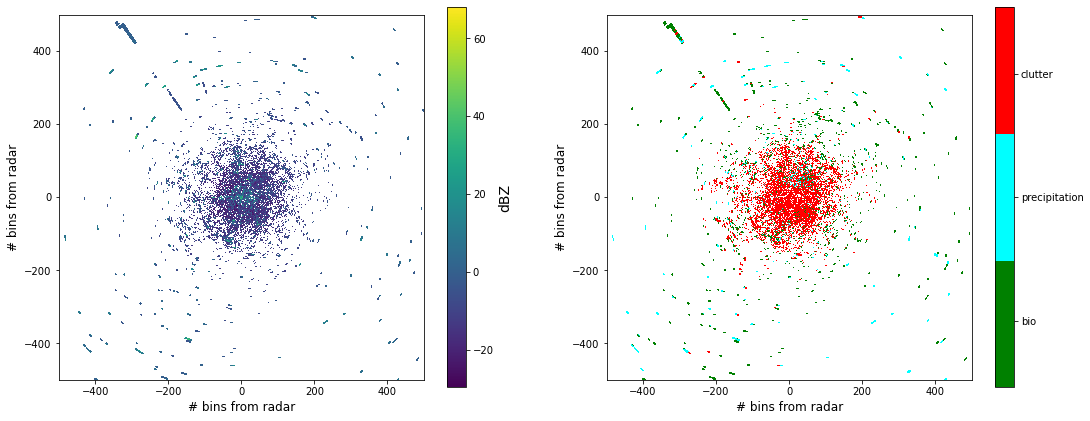

In [50]:
### NLDHL 18/02/2019 14:15 clutter only case
data_path = "C:/Users/leona/Desktop/Data/"
files = sorted(glob.glob(data_path + 'NLHRW_pvol_20190218T1415_6356.h5'))  
dataset_idx = 6
radfile = files[0]
print(radfile)

classi_clu_pol = func_classi_pol(radfile, dataset_idx)
classi_clu = func_classi(radfile, dataset_idx)

### Apply algorithm to 1) bio + clutter and 2) prec + clutter cases to calculate false alarm

#### 1) bio + clutter

C:/Users/leona/Desktop/Data/NLHRW_pvol_20190420T2235_6356.h5


C:\Users\leona\AppData\Local\Temp/ipykernel_5912/1637127489.py:5: RuntimeWarning: invalid value encountered in log10
  DR = 10*np.log10(Dr)
C:\Users\leona\anaconda3\envs\myenv\lib\site-packages\wradlib\dp.py:560: RuntimeWarning: invalid value encountered in true_divide
  rmsd = np.sqrt(np.nansum((xa - data) ** 2, axis=0) / xa_valid_count)
C:\Users\leona\AppData\Local\Temp/ipykernel_5912/1637127489.py:5: RuntimeWarning: invalid value encountered in log10
  DR = 10*np.log10(Dr)
C:\Users\leona\anaconda3\envs\myenv\lib\site-packages\wradlib\dp.py:560: RuntimeWarning: invalid value encountered in true_divide
  rmsd = np.sqrt(np.nansum((xa - data) ** 2, axis=0) / xa_valid_count)


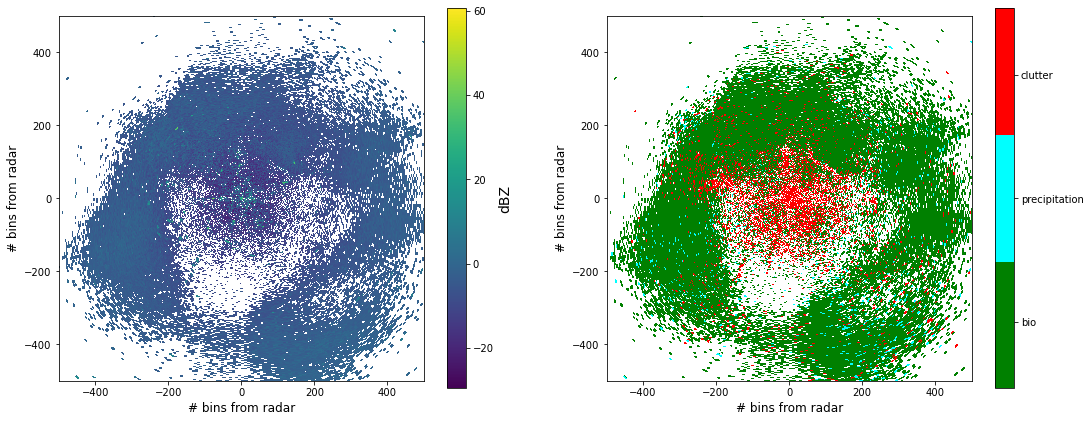

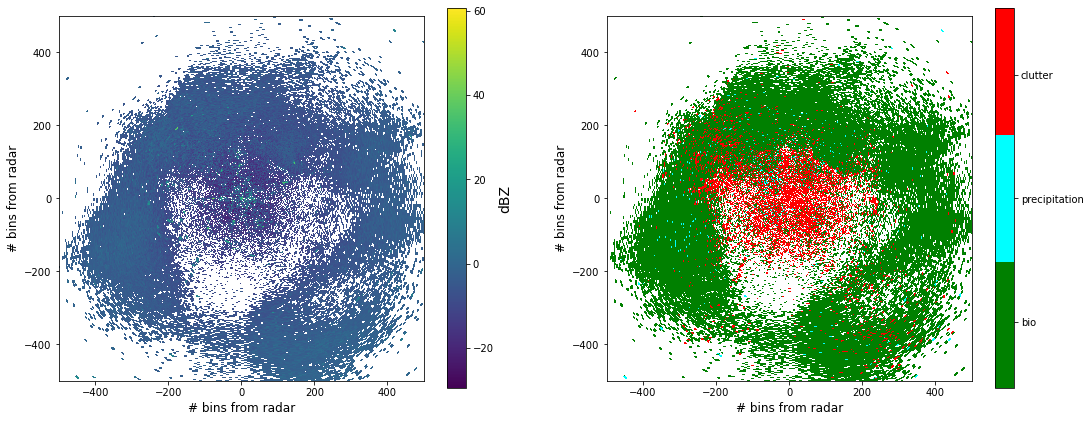

In [51]:
### NLHRW 20/04/2019 22:35
data_path = "C:/Users/leona/Desktop/Data/"
files = sorted(glob.glob(data_path + 'NLHRW_pvol_20190420T2235_6356.h5'))  
dataset_idx = 6
radfile = files[0]
print(radfile)

classi_bio_pol = func_classi_pol(radfile, dataset_idx)
#plt.tight_layout()
#plt.savefig(OUT_PATH + 'vali_pol_NLHRW_20190420_2235', facecolor='white')

classi_bio = func_classi(radfile, dataset_idx)
#plt.tight_layout()
#plt.savefig(OUT_PATH + 'vali_NLHRW_20190420_2235', facecolor='white')

#### Evaluate the imporvement

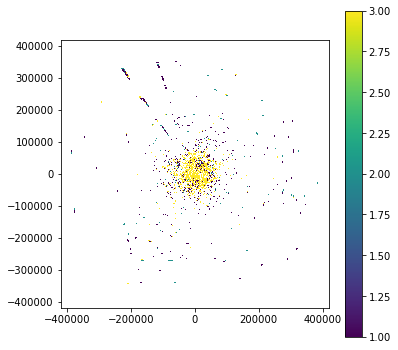

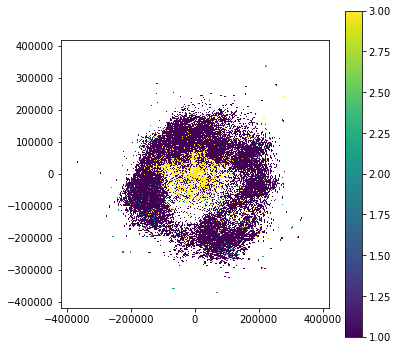

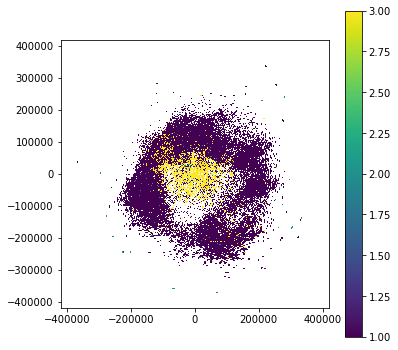

In [52]:
polar_plotter(classi_clu_pol)
polar_plotter(classi_bio_pol)
polar_plotter(classi_bio)

masked_pol = np.copy(classi_bio_pol)
masked = np.copy(classi_bio)

masked_pol[classi_clu_pol==3]=np.nan
masked[classi_clu_pol==3]=np.nan

In [53]:
#if bio=3 & clutter=3: hit
#if bio=1 & clutter=3: fa
#if bio=2 & clutter=3: no
#if bio=1 & clutter=nan: hit

In [54]:
print('Polarimetric')
print('no. of clutter pixels: ', len(classi_clu_pol[classi_clu_pol==3]))
print('no. of correclty identified pixels (hits): ', len(classi_clu_pol[np.all([classi_clu_pol==3, classi_bio_pol==3],axis=0)]))
print('no. of incorrectly identified pixels (fa): ', len(classi_clu_pol[np.all([classi_clu_pol==3, classi_bio_pol!=3],axis=0)]))
print('')


print('non-Polarimetric')
print('no. of clutter pixels: ', len(classi_clu_pol[classi_clu_pol==3]))
print('no. of correclty identified pixels (hits): ', len(classi_clu_pol[np.all([classi_clu_pol==3, classi_bio==3],axis=0)]))
print('no. of incorrectly identified pixels (fa): ', len(classi_clu_pol[np.all([classi_clu_pol==3, classi_bio!=3],axis=0)]))
print('')

Polarimetric
no. of clutter pixels:  22113
no. of correclty identified pixels (hits):  12209
no. of incorrectly identified pixels (fa):  9904

non-Polarimetric
no. of clutter pixels:  22113
no. of correclty identified pixels (hits):  14075
no. of incorrectly identified pixels (fa):  8038



#### 2) prec + clutter

C:/Users/leona/Desktop/Data/NLHRW_pvol_20200218T2125_6356.h5


C:\Users\leona\AppData\Local\Temp/ipykernel_5912/1637127489.py:5: RuntimeWarning: invalid value encountered in log10
  DR = 10*np.log10(Dr)
C:\Users\leona\anaconda3\envs\myenv\lib\site-packages\wradlib\dp.py:560: RuntimeWarning: invalid value encountered in true_divide
  rmsd = np.sqrt(np.nansum((xa - data) ** 2, axis=0) / xa_valid_count)
C:\Users\leona\AppData\Local\Temp/ipykernel_5912/1637127489.py:5: RuntimeWarning: invalid value encountered in log10
  DR = 10*np.log10(Dr)
C:\Users\leona\anaconda3\envs\myenv\lib\site-packages\wradlib\dp.py:560: RuntimeWarning: invalid value encountered in true_divide
  rmsd = np.sqrt(np.nansum((xa - data) ** 2, axis=0) / xa_valid_count)


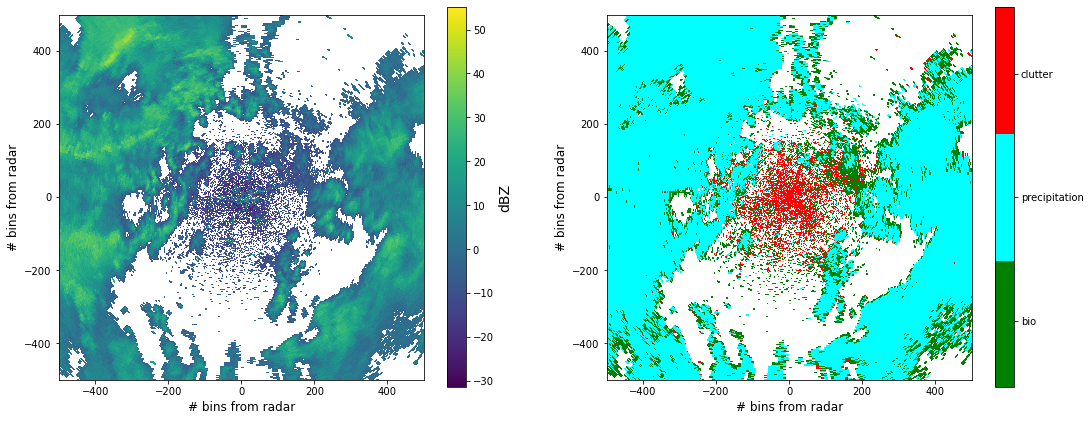

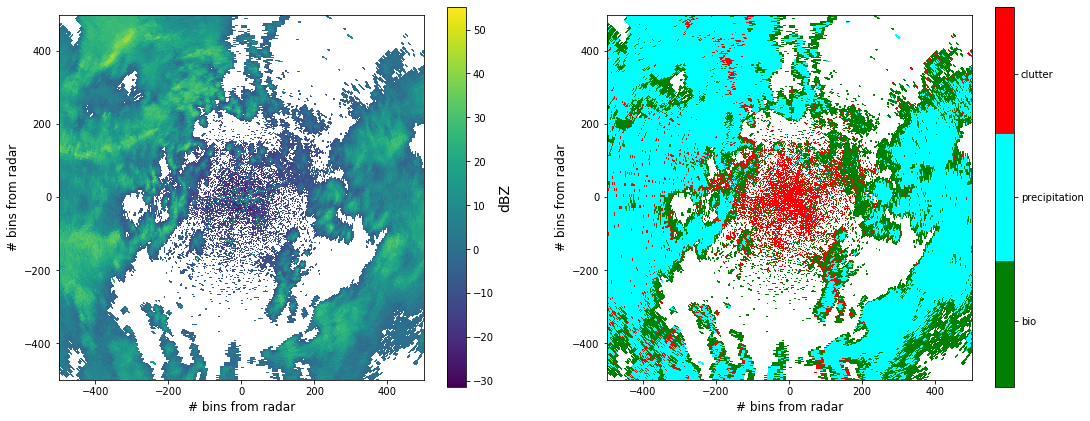

In [55]:
### NLHRW 18/02/2020 21:25
data_path = "C:/Users/leona/Desktop/Data/"
files = sorted(glob.glob(data_path + 'NLHRW_pvol_20200218T2125_6356.h5'))  
dataset_idx = 6
radfile = files[0]
print(radfile)

classi_prec_pol = func_classi_pol(radfile, dataset_idx)
#plt.tight_layout()
#plt.savefig(OUT_PATH + 'vali_pol_NLHRW_20200218_2125', facecolor='white')

classi_prec = func_classi(radfile, dataset_idx)
#plt.tight_layout()
#plt.savefig(OUT_PATH + 'vali_NLHRW_20200218_2125', facecolor='white')

<AxesSubplot:>

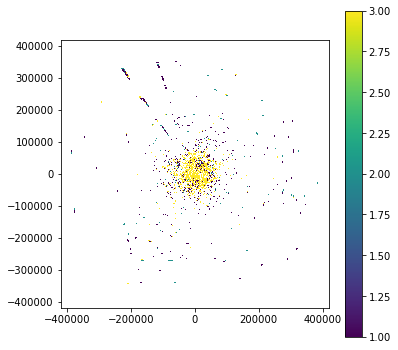

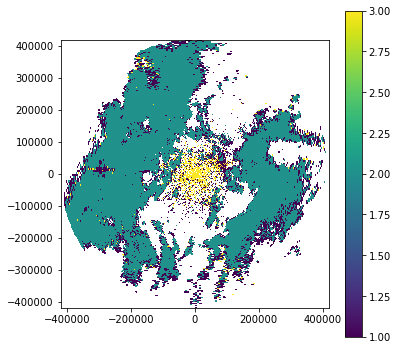

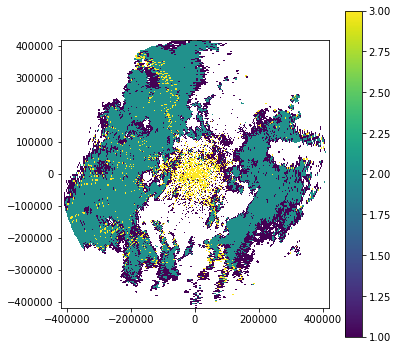

In [56]:
polar_plotter(classi_clu_pol)
polar_plotter(classi_prec_pol)
polar_plotter(classi_prec)

In [57]:
print('Polarimetric')
print('no. of clutter pixels: ', len(classi_clu_pol[classi_clu_pol==3]))
print('no. of correclty identified pixels (hits): ', len(classi_clu_pol[np.all([classi_clu_pol==3, classi_prec_pol==3],axis=0)]))
print('no. of incorrectly identified pixels (fa): ', len(classi_clu_pol[np.all([classi_clu_pol==3, classi_prec_pol!=3],axis=0)]))
print('')


print('non-Polarimetric')
print('no. of clutter pixels: ', len(classi_clu_pol[classi_clu_pol==3]))
print('no. of correclty identified pixels (hits): ', len(classi_clu_pol[np.all([classi_clu_pol==3, classi_prec==3],axis=0)]))
print('no. of incorrectly identified pixels (fa): ', len(classi_clu_pol[np.all([classi_clu_pol==3, classi_prec!=3],axis=0)]))
print('')

Polarimetric
no. of clutter pixels:  22113
no. of correclty identified pixels (hits):  12580
no. of incorrectly identified pixels (fa):  9533

non-Polarimetric
no. of clutter pixels:  22113
no. of correclty identified pixels (hits):  14306
no. of incorrectly identified pixels (fa):  7807

